## Import Statements

In [1]:
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from pathlib import Path


# Data Settings

In [7]:
DATA_PATH = Path(f"./1000-words-kept-data/")
NUMBER_OF_COMPONENTS = [20, 30, 40, 50, 60]

# Clustering and Visualizing

In [14]:
def cluster_and_visualize(filepath, n_clusters=6):
    """
    Loads a dimensionality-reduced CSV file, performs KMeans and Agglomerative clustering,
    visualizes the results, and returns silhouette scores for both clustering methods.

    Parames:
        filepath (str): Path to the CSV file containing dimensionality-reduced features + metadata.
        n_clusters (int): Number of clusters for KMeans and Agglomerative clustering.

    Returns:
        List[dict]: Clustering results with silhouette scores and metadata.
    """
    # -------------------------
    # Load and preprocess data
    # -------------------------
    df = pd.read_csv(filepath)

    # Select dimensionality-reduced features (PCA/SVD components)
    feature_cols = [col for col in df.columns if col.startswith("SVD_") or col.startswith("PC")]
    X = df[feature_cols].values
    X_scaled = StandardScaler().fit_transform(X)

    # -------------------------
    # Perform clustering
    # -------------------------
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)     # KMeans clustering
    df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

    agg = AgglomerativeClustering(n_clusters=n_clusters)     # Agglomerative clustering
    df['Agglomerative_Cluster'] = agg.fit_predict(X_scaled)

    # -------------------------
    # Reduce to 2D for plotting
    # -------------------------
    if X_scaled.shape[1] > 2:
        pca_2d = PCA(n_components=2)
        X_2d = pca_2d.fit_transform(X_scaled)
    else:
        X_2d = X_scaled  # Use raw features if already 2D

    df['PC1'], df['PC2'] = X_2d[:, 0], X_2d[:, 1]

    # Generate plot-friendly dataset name
    plot_title = filepath.split("/")[-1].replace(".csv", "").replace("_", " ").title()

    # -------------------------
    # Visualize clustering + heatmaps
    # -------------------------
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f"Clustering Analysis – {plot_title}", fontsize=16, y=0.95)

    sns.scatterplot(data=df, x='PC1', y='PC2', hue='KMeans_Cluster', style='Sector',     # KMeans scatter plot
                    palette='tab10', s=70, ax=axes[0, 0])
    axes[0, 0].set_title("KMeans Clusters (2D PCA View)")
    axes[0, 0].set_xlabel("PC1")
    axes[0, 0].set_ylabel("PC2")

    sns.scatterplot(data=df, x='PC1', y='PC2', hue='Agglomerative_Cluster', style='Sector',     # Agglomerative scatter plot
                    palette='tab10', s=70, ax=axes[0, 1])
    axes[0, 1].set_title("Agglomerative Clusters (2D PCA View)")
    axes[0, 1].set_xlabel("PC1")
    axes[0, 1].set_ylabel("PC2")

    # Cluster vs Sector heatmaps
    kmeans_ct = pd.crosstab(df['KMeans_Cluster'], df['Sector'])
    agg_ct = pd.crosstab(df['Agglomerative_Cluster'], df['Sector'])

    sns.heatmap(kmeans_ct, annot=True, fmt="d", cmap="YlGnBu", cbar=False, ax=axes[1, 0])
    axes[1, 0].set_title("KMeans Cluster vs Sector")
    axes[1, 0].set_xlabel("True Label (Sector)")
    axes[1, 0].set_ylabel("Predicted Label (KMeans)")
    axes[1, 0].tick_params(axis='x', rotation=45)

    sns.heatmap(agg_ct, annot=True, fmt="d", cmap="YlGnBu", cbar=False, ax=axes[1, 1])
    axes[1, 1].set_title("Agglomerative Cluster vs Sector")
    axes[1, 1].set_xlabel("True Label (Sector)")
    axes[1, 1].set_ylabel("Predicted Label (Agglomerative)")
    axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # -------------------------
    # Evaluate clustering
    # -------------------------
    kmeans_sil = silhouette_score(X_scaled, df['KMeans_Cluster'])
    agg_sil = silhouette_score(X_scaled, df['Agglomerative_Cluster'])

    return [
        {
            "Dataset": plot_title,
            "Components": X_scaled.shape[1],
            "Method": "KMeans",
            "Silhouette Score": kmeans_sil
        },
        {
            "Dataset": plot_title,
            "Components": X_scaled.shape[1],
            "Method": "Agglomerative",
            "Silhouette Score": agg_sil
        }
    ]

## Clustering 50 Components

### Comments:

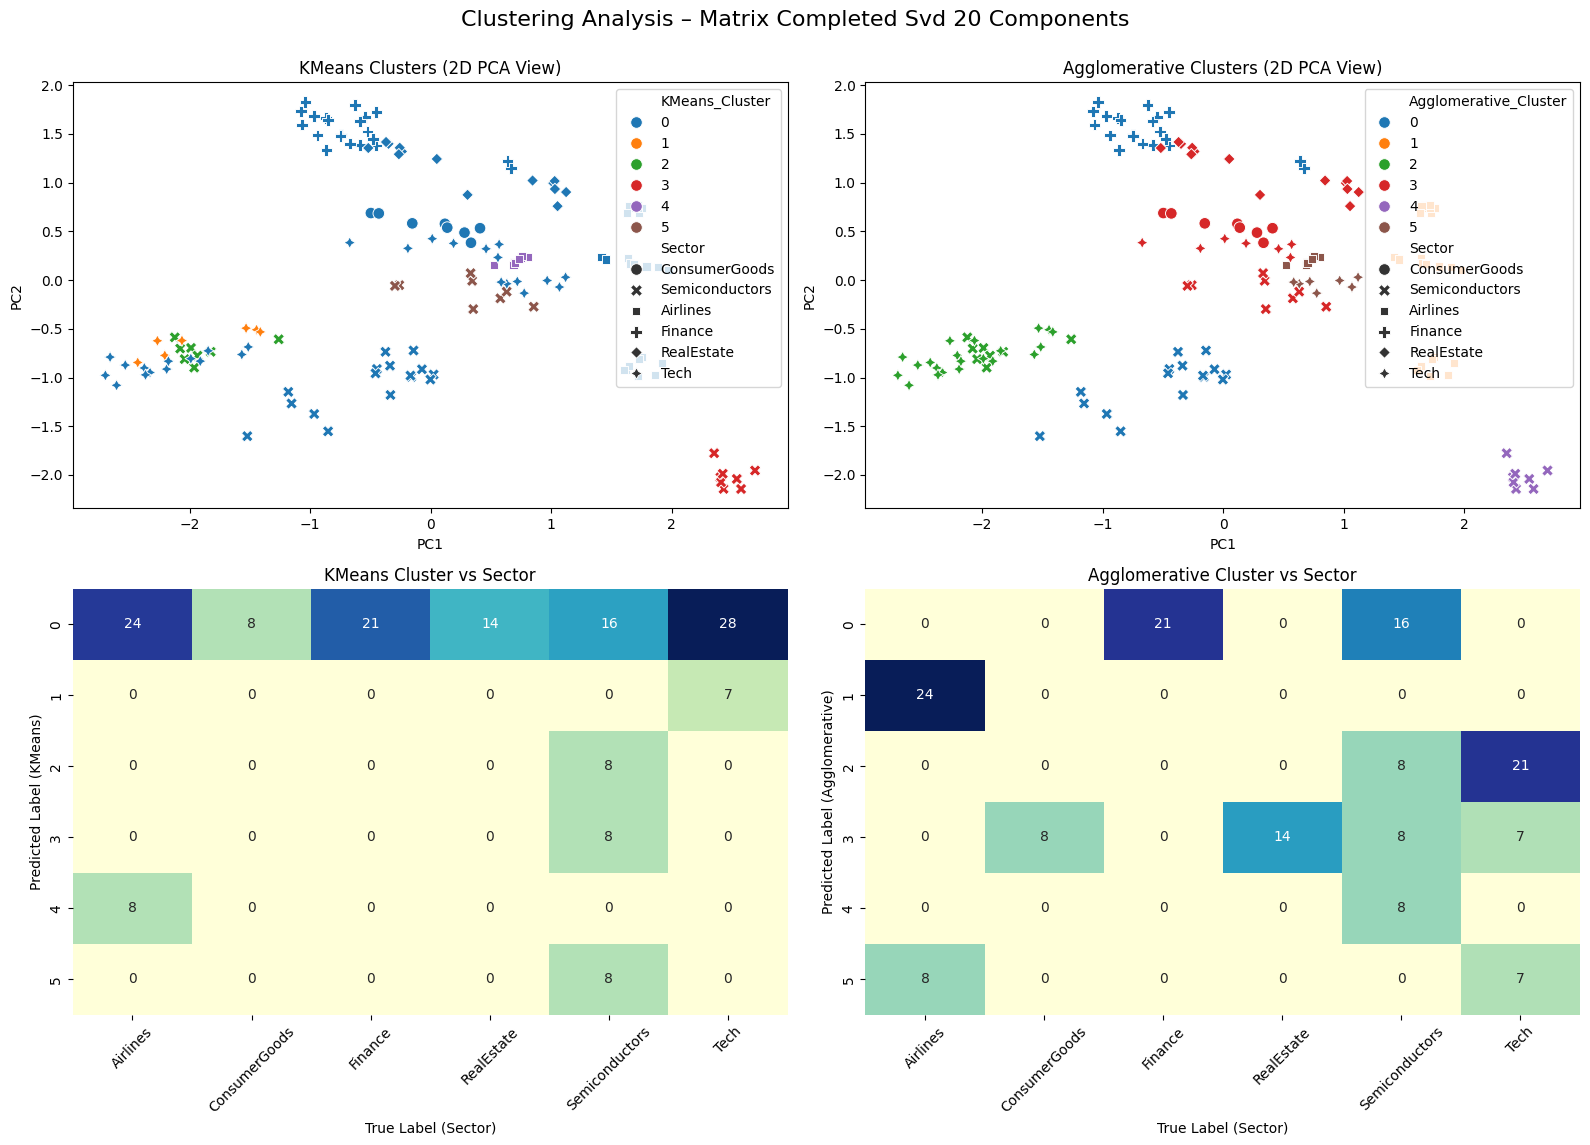

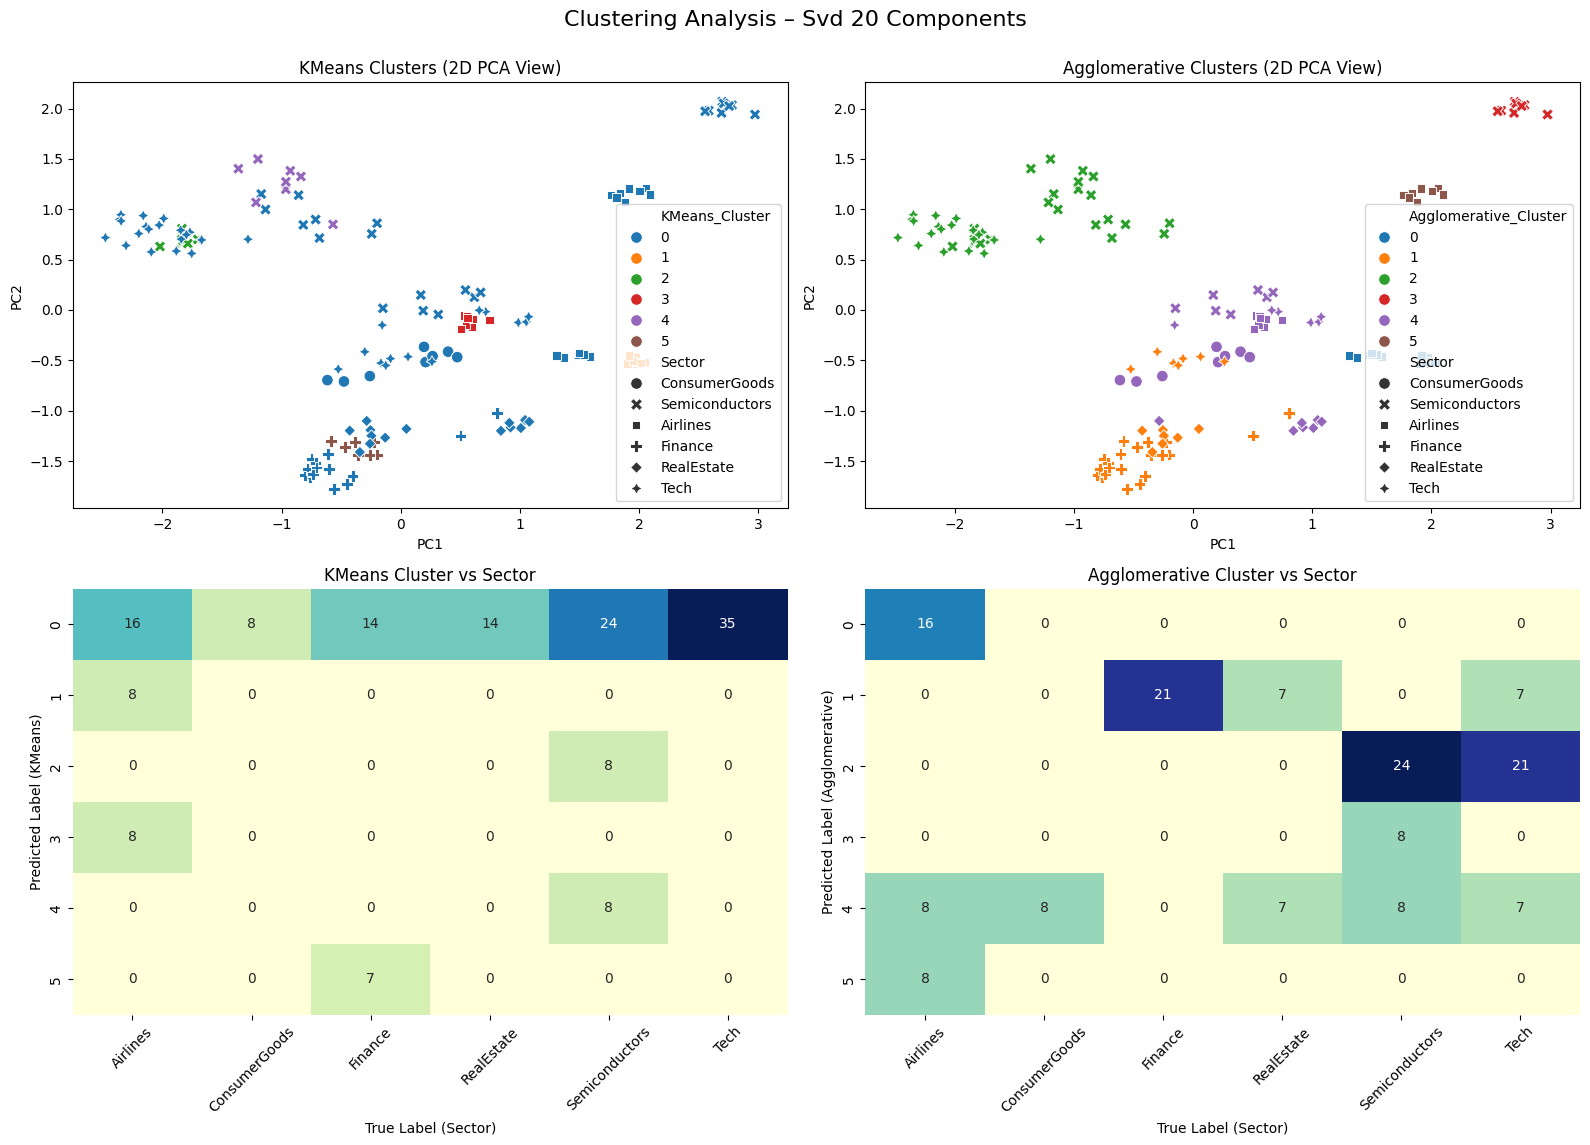

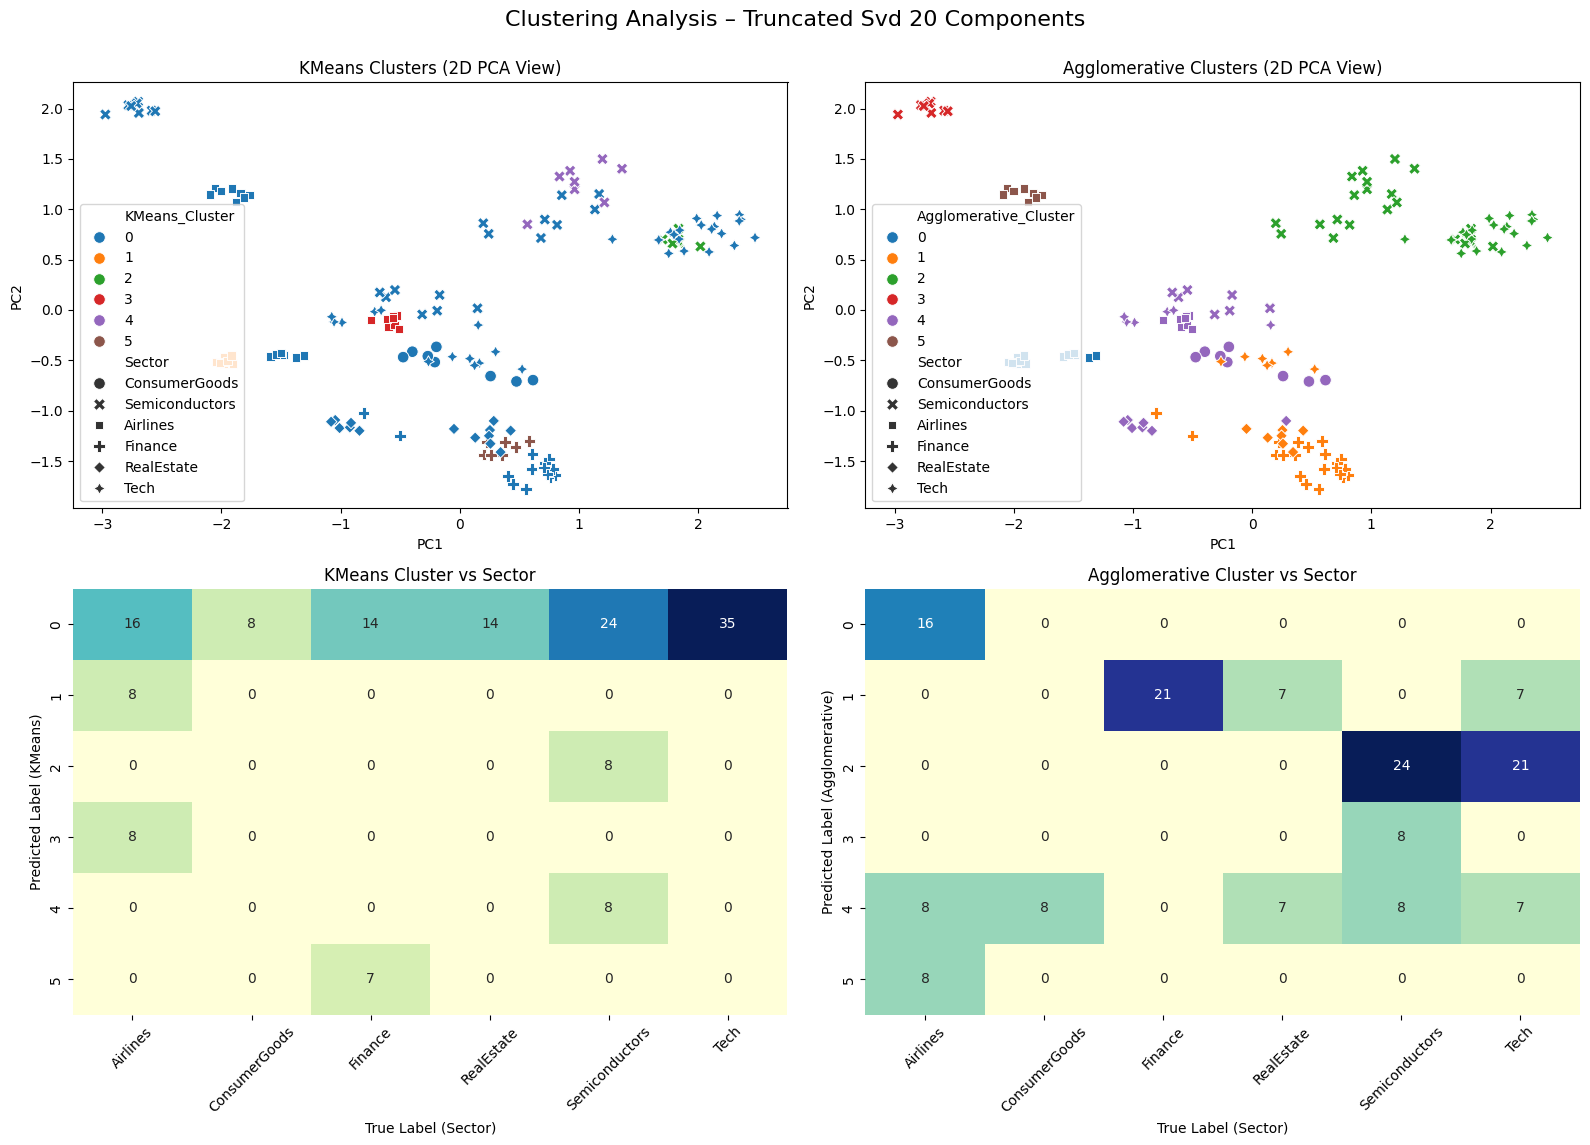

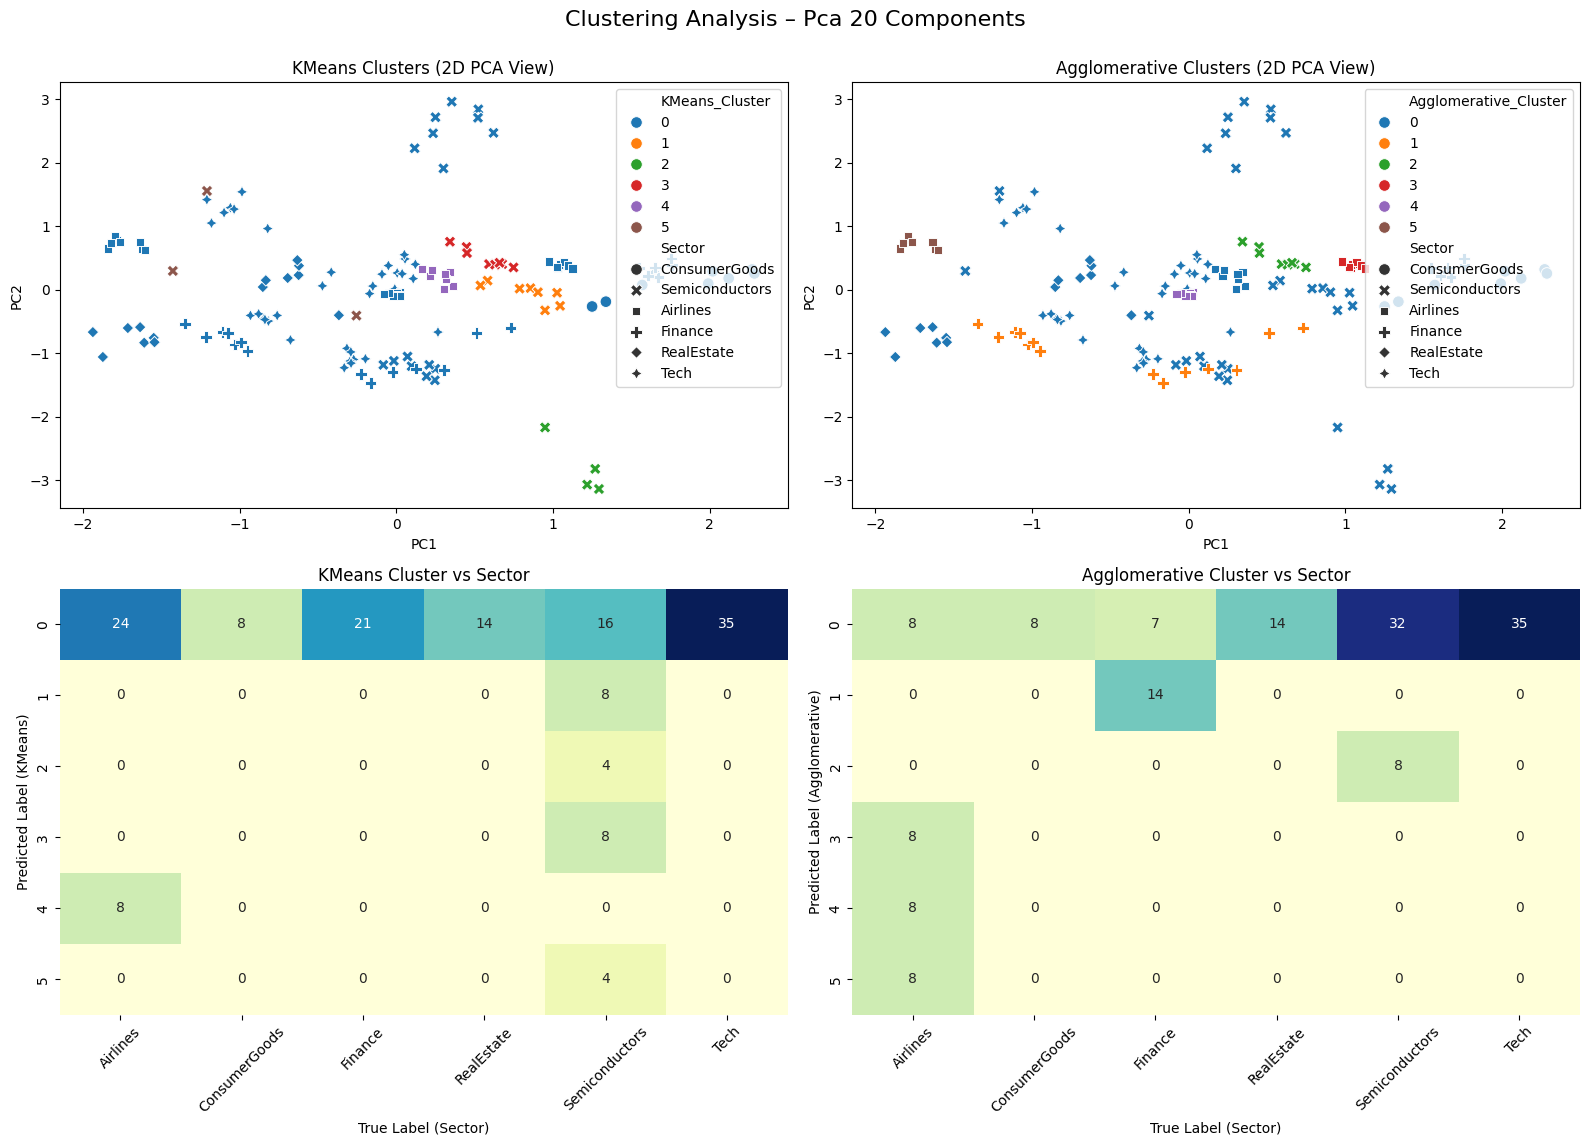

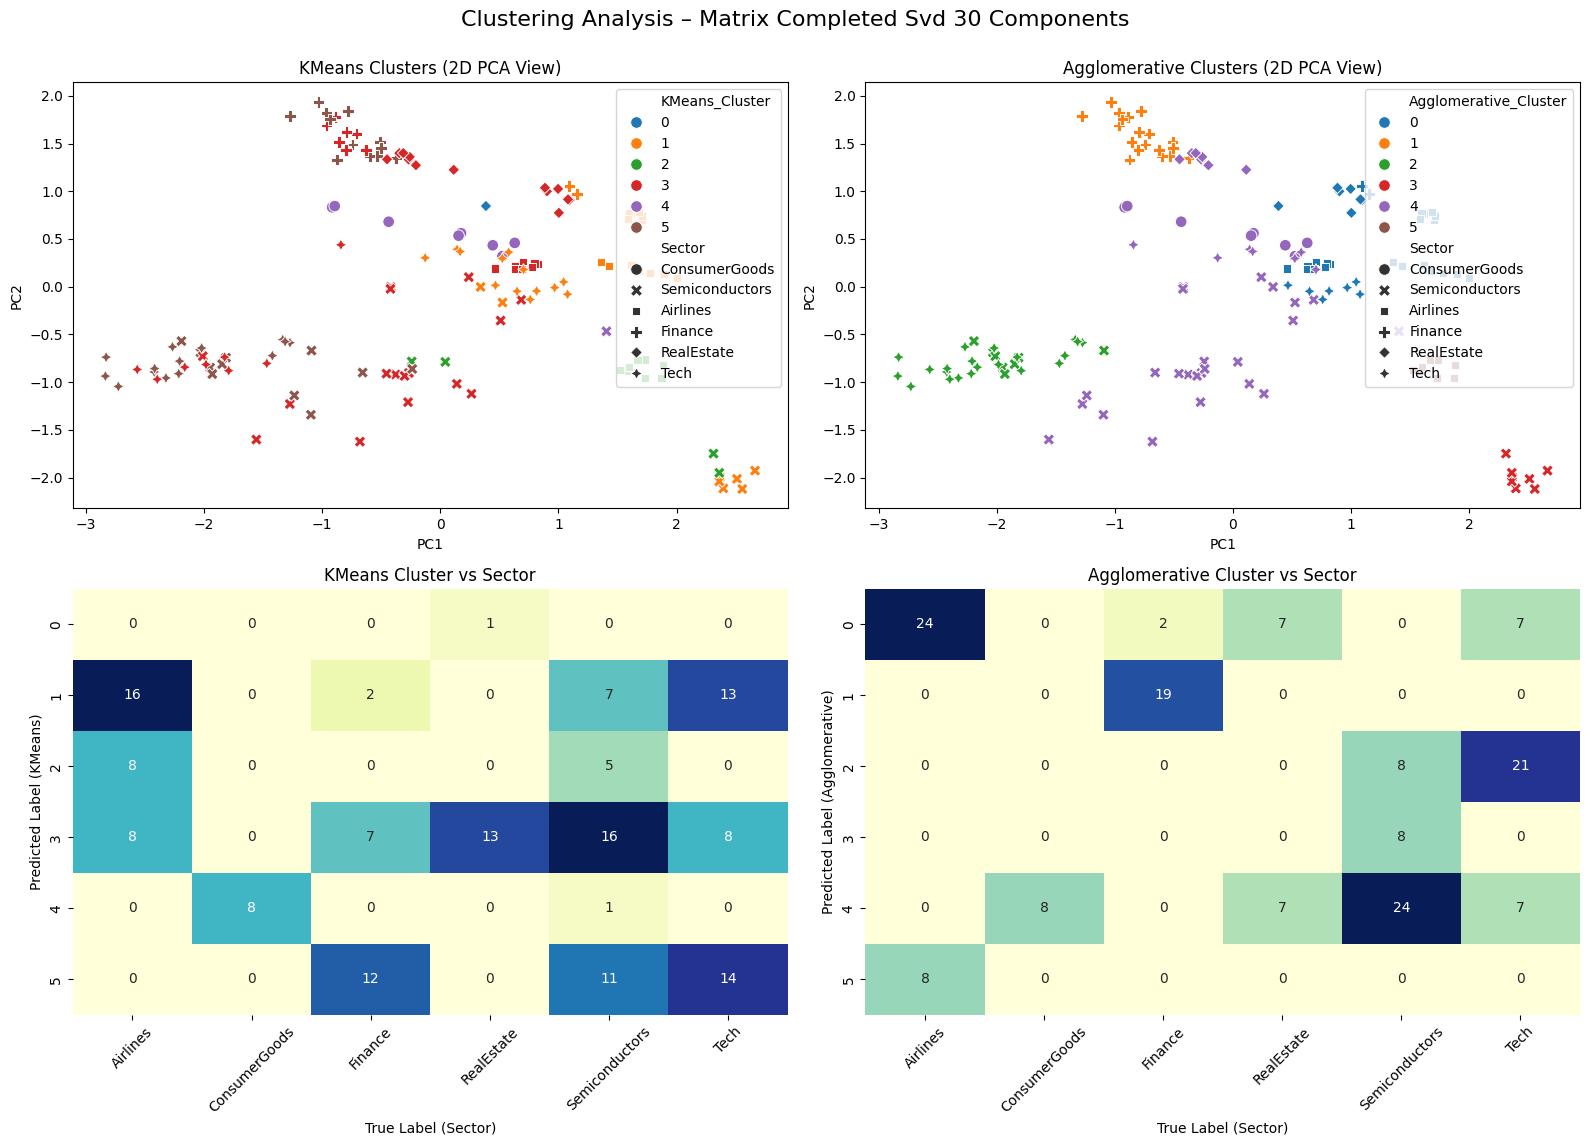

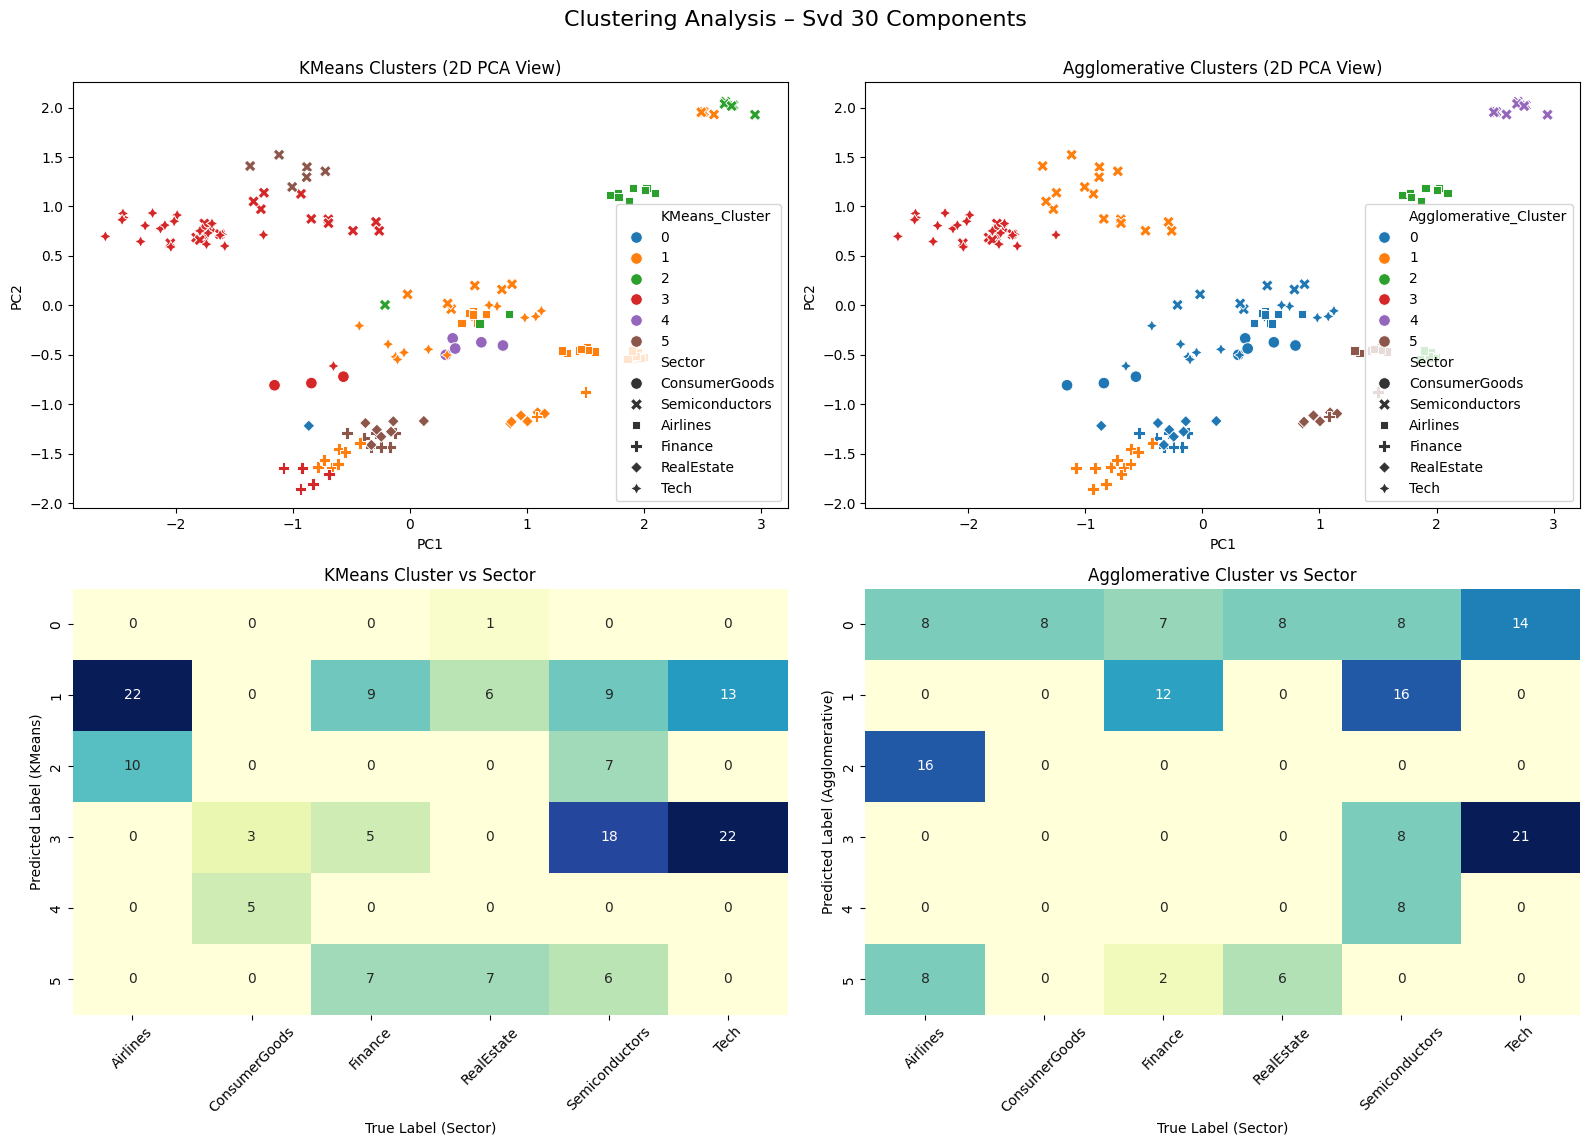

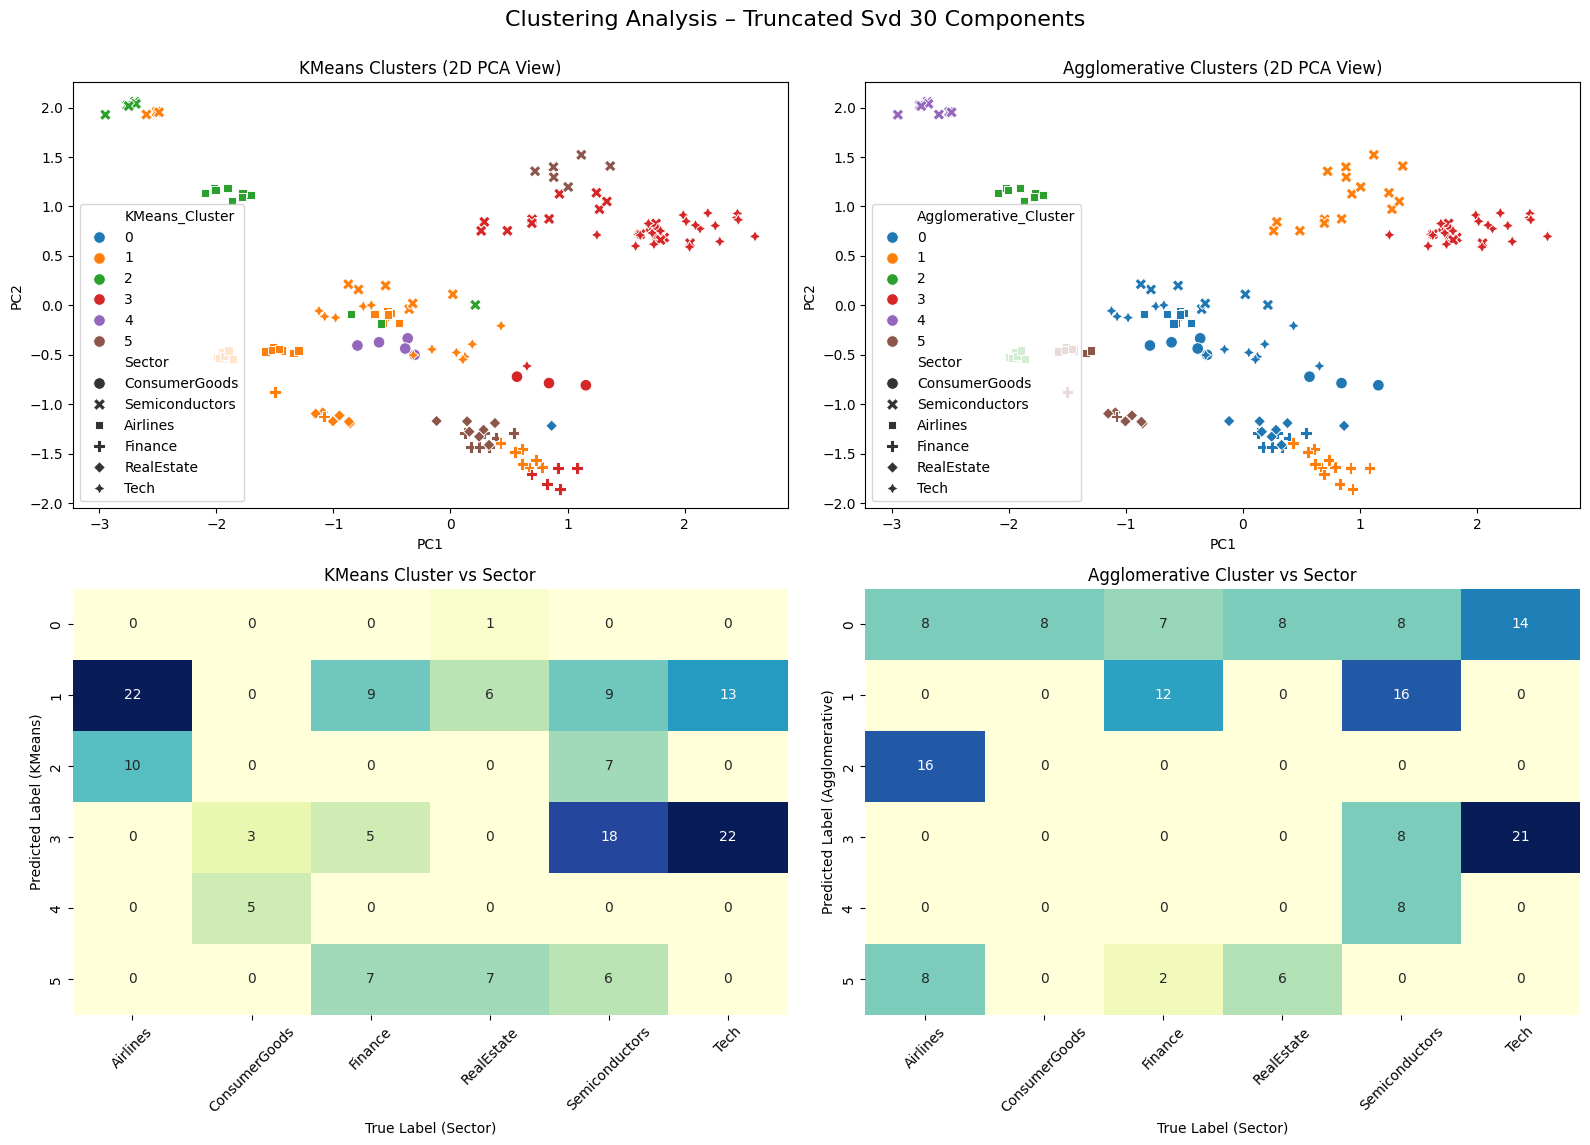

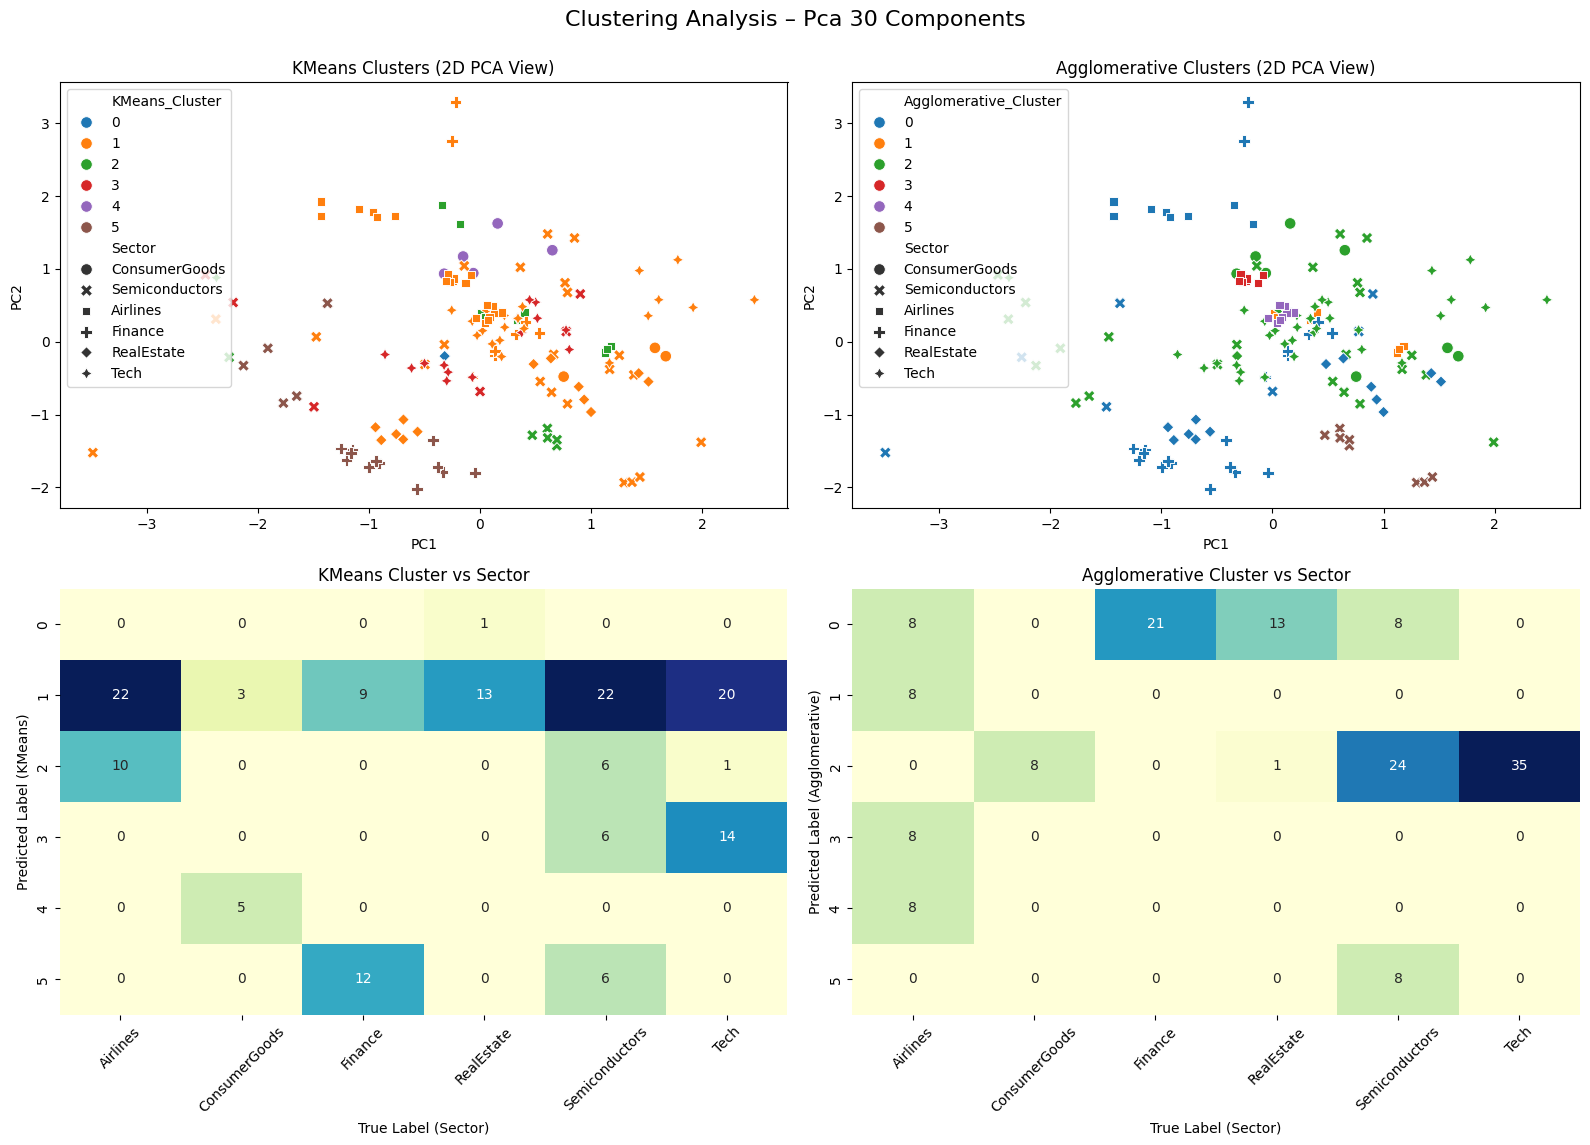

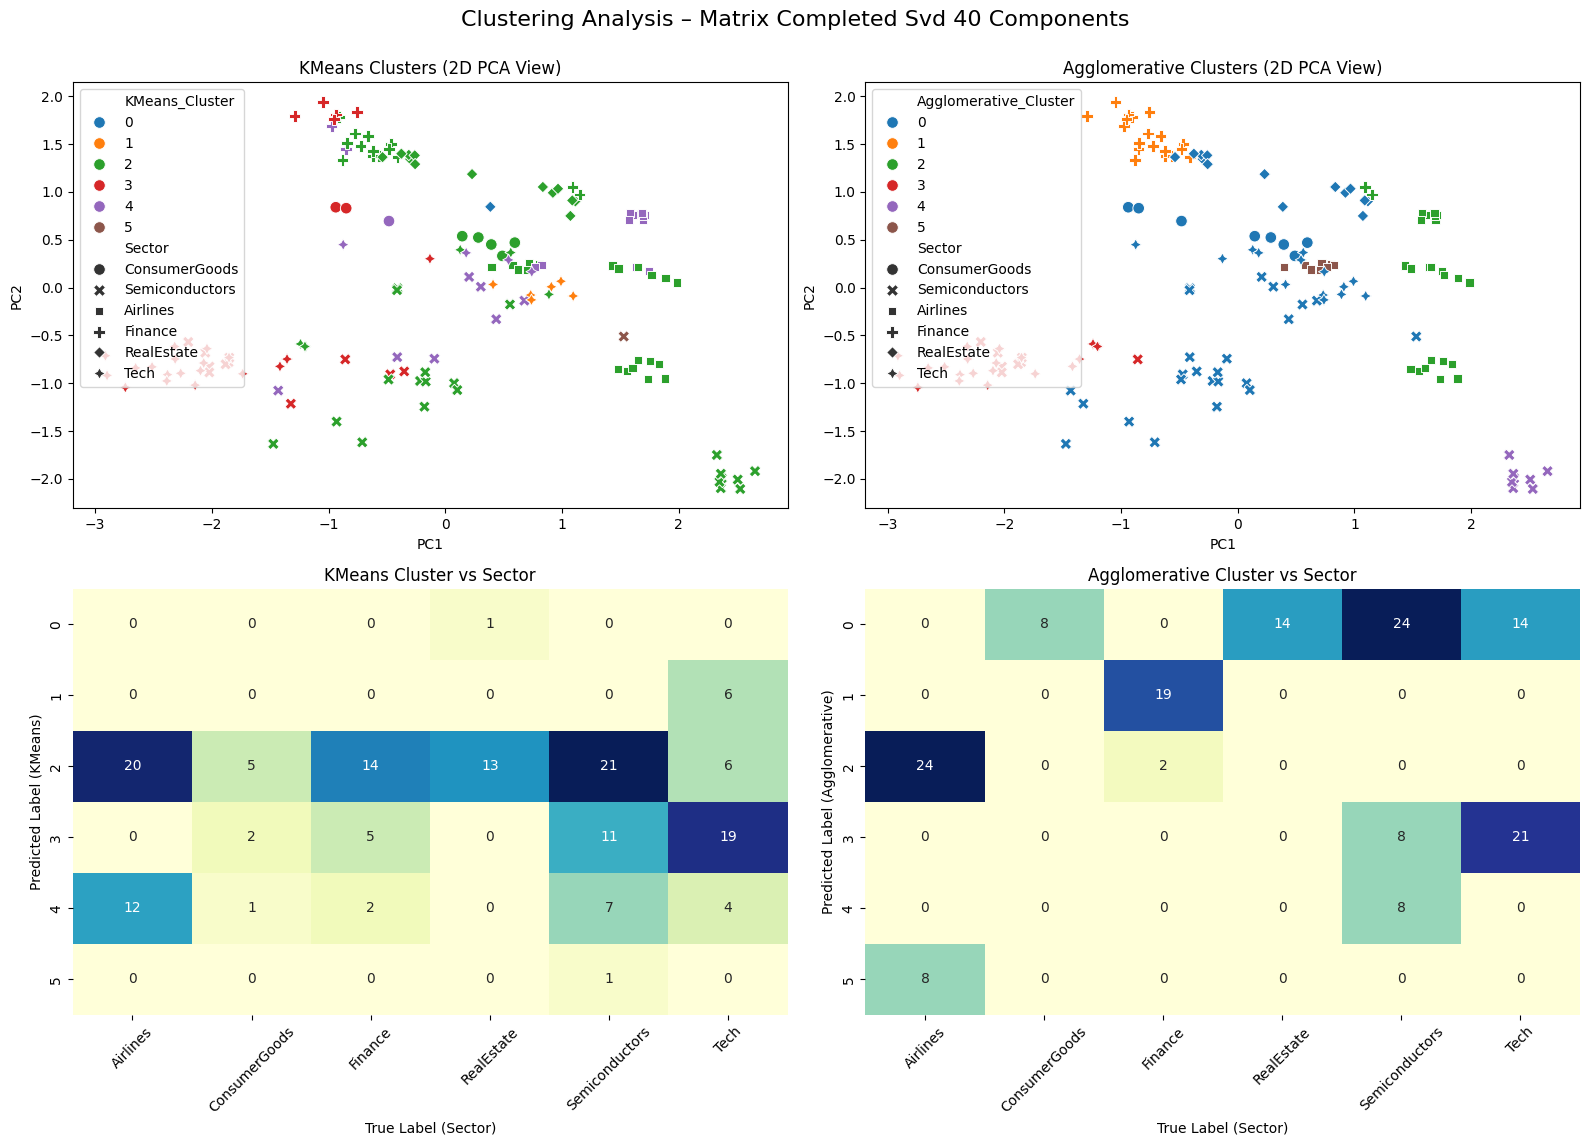

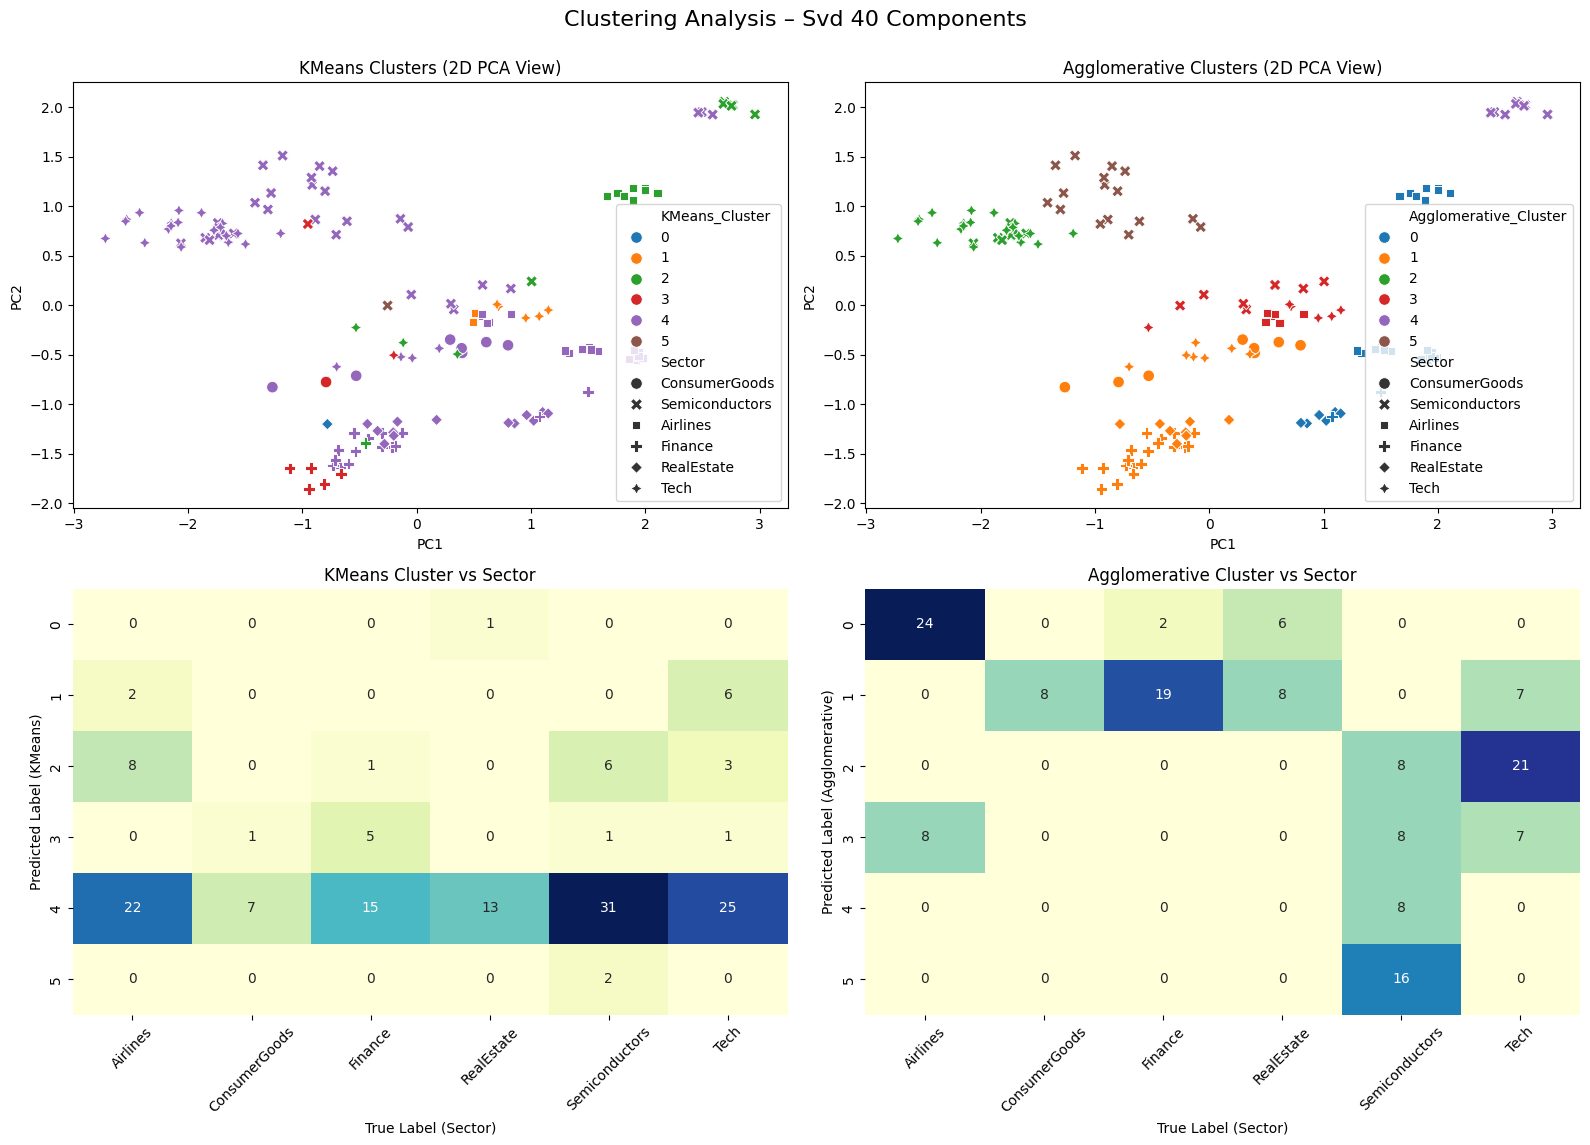

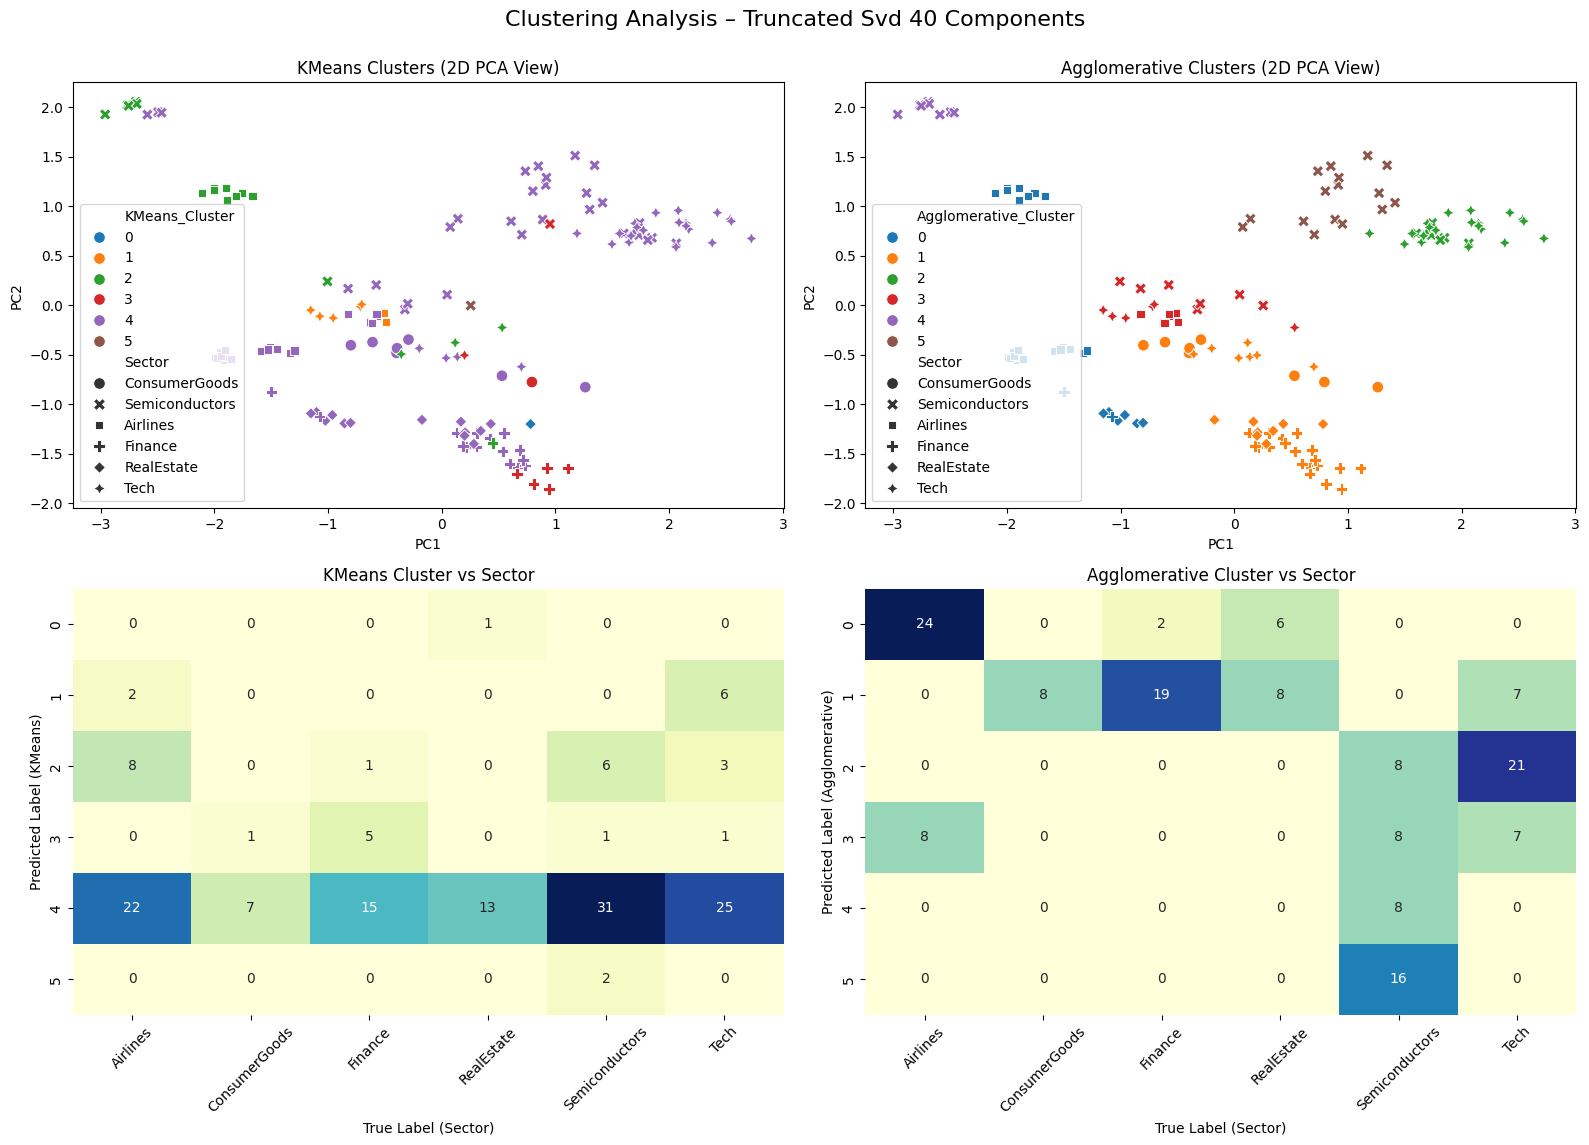

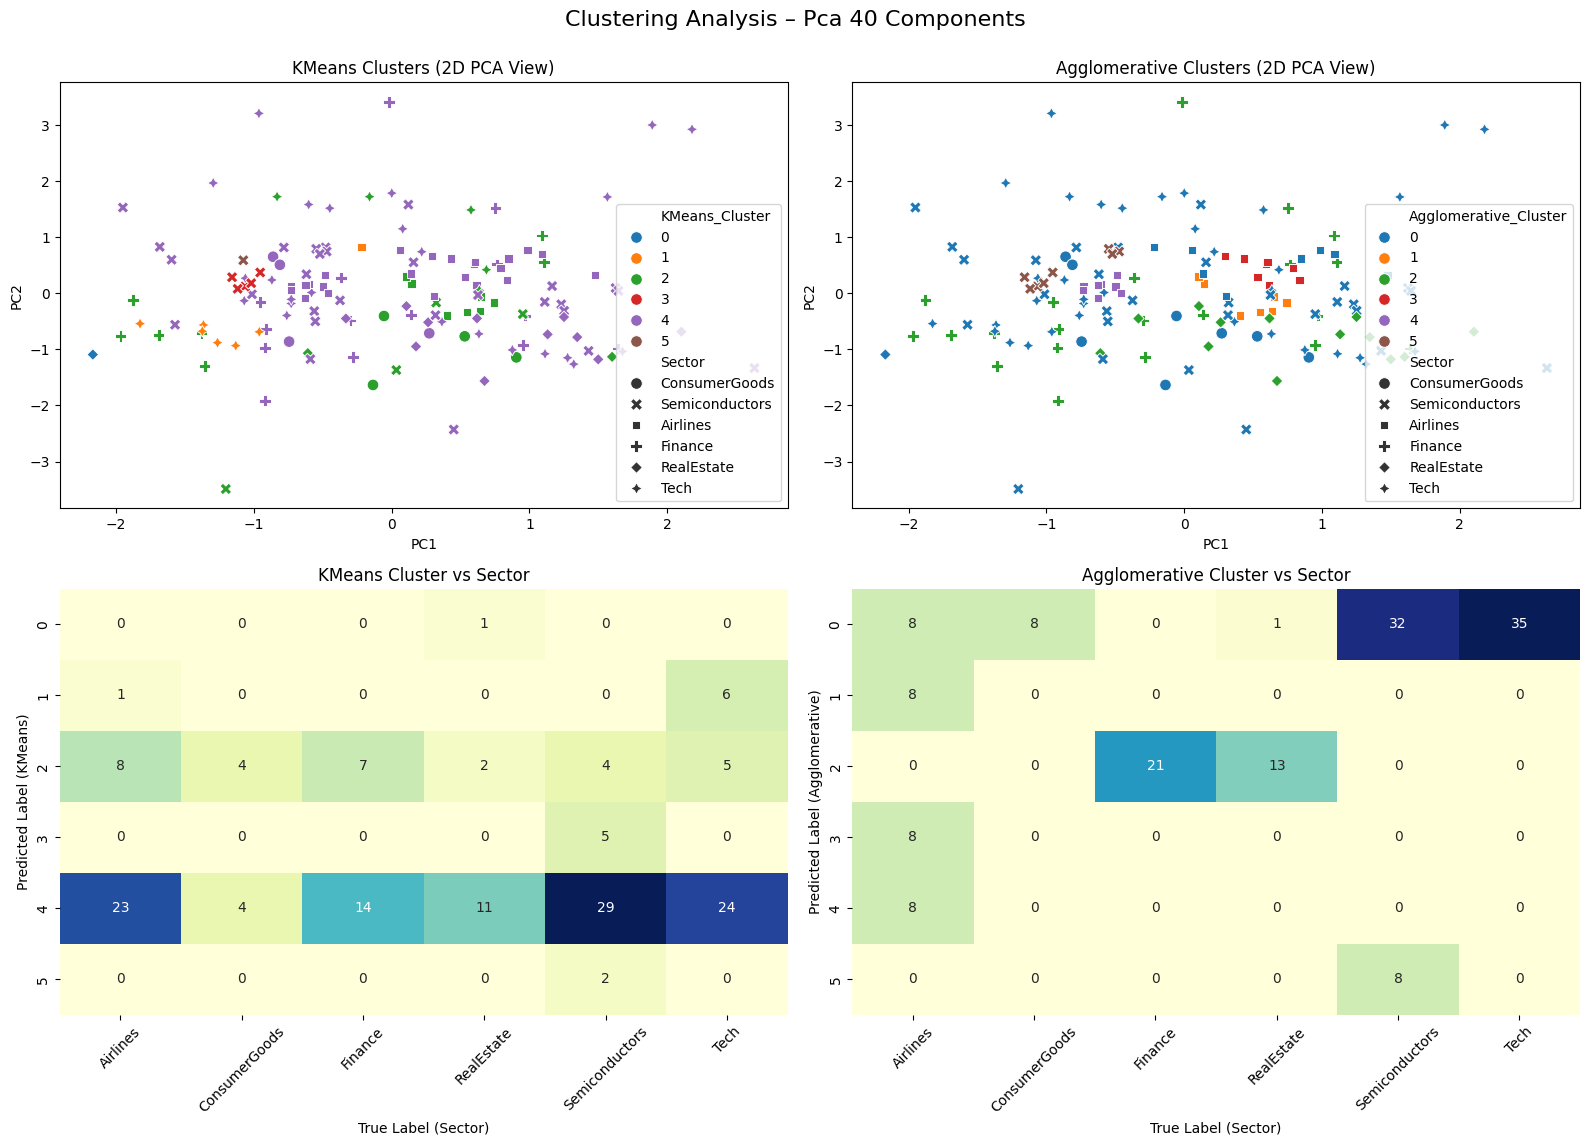

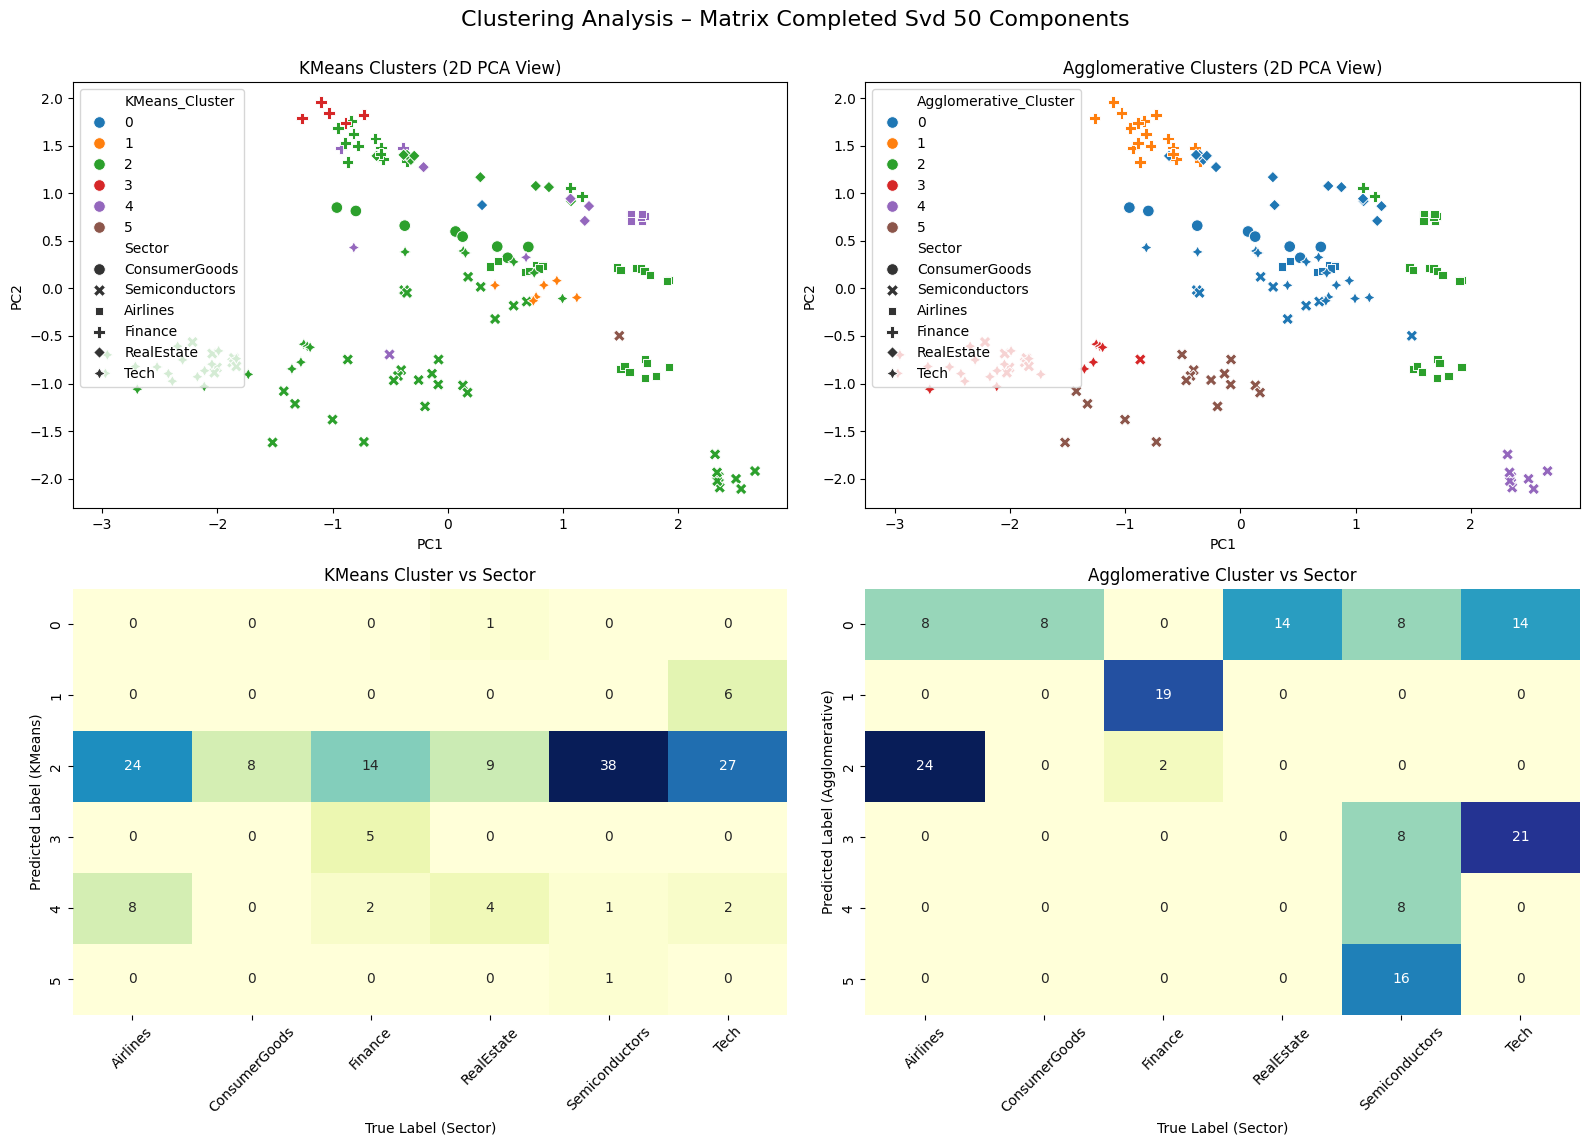

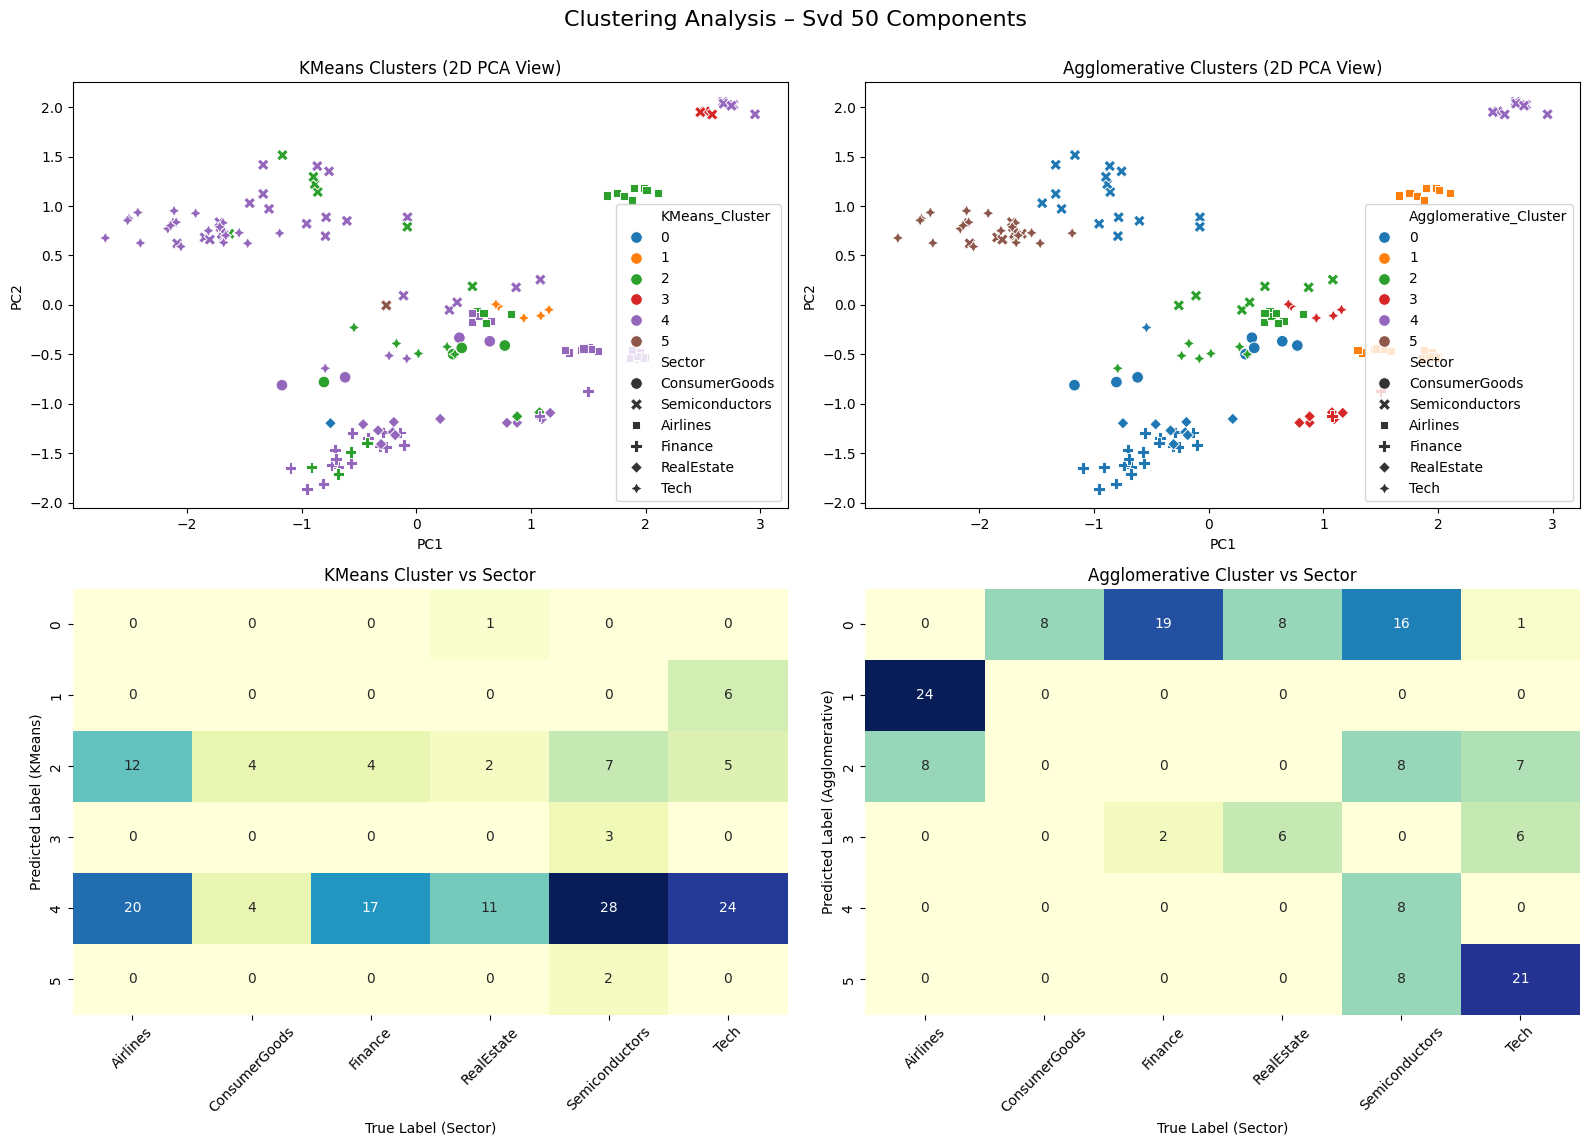

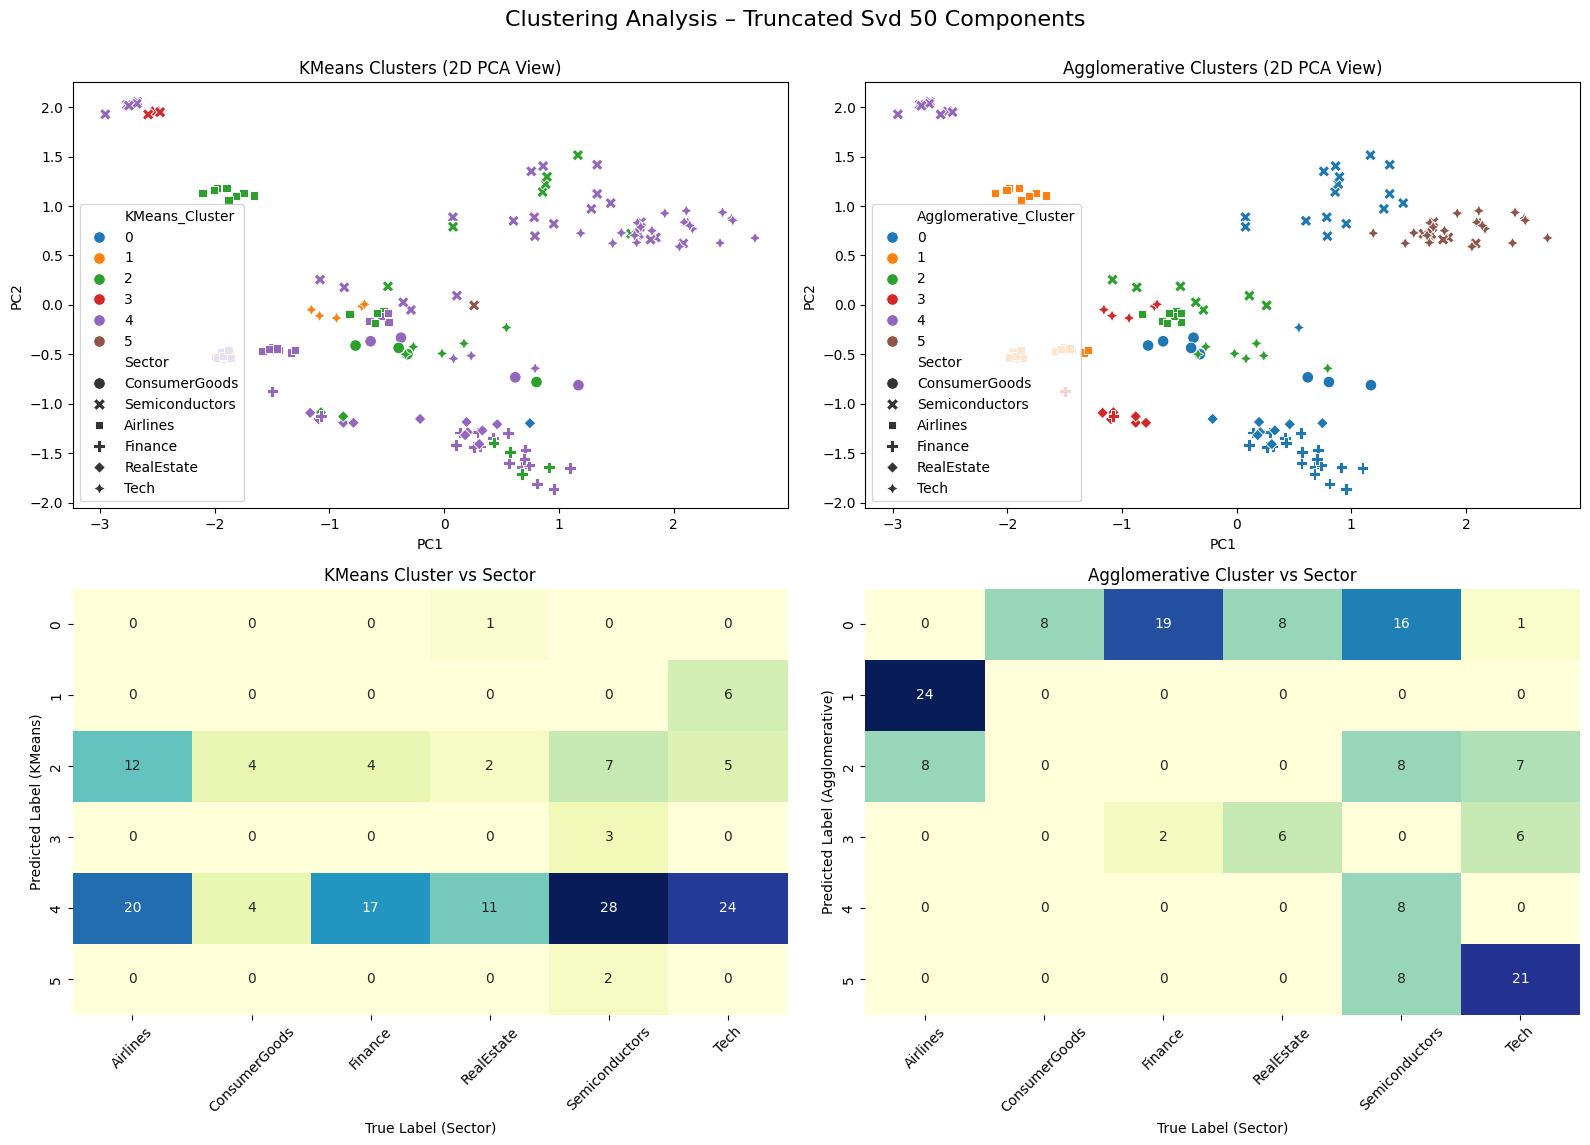

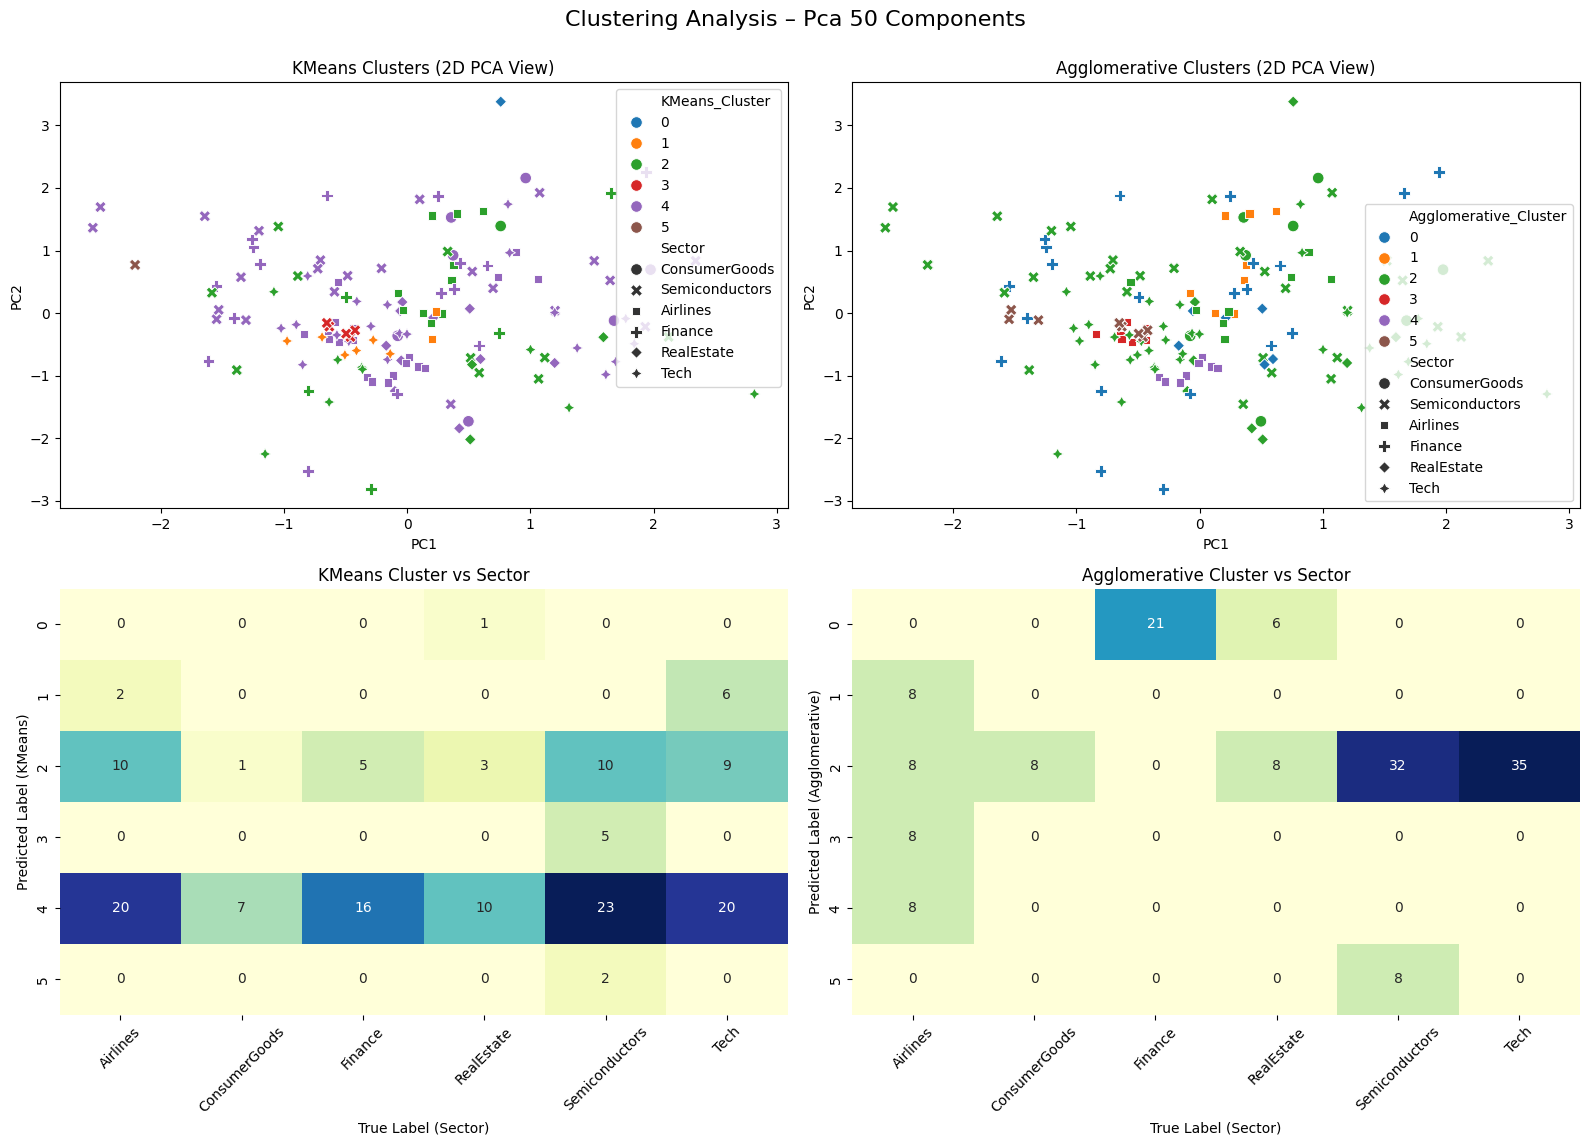

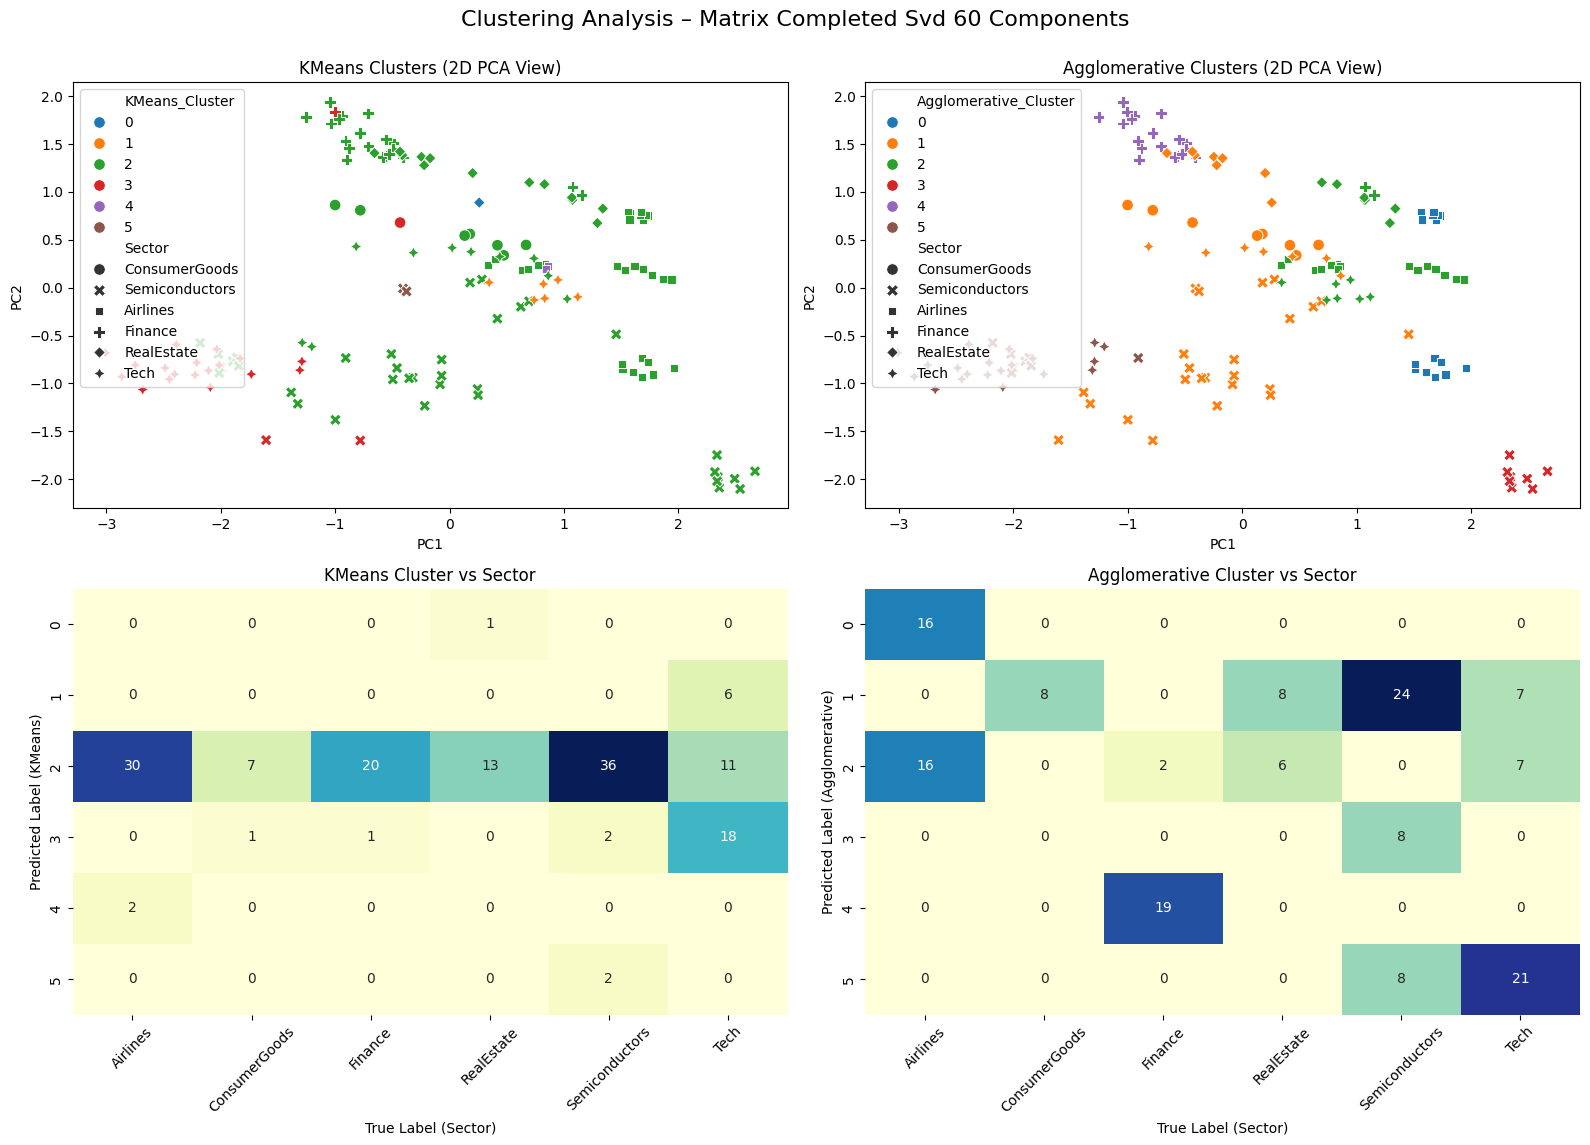

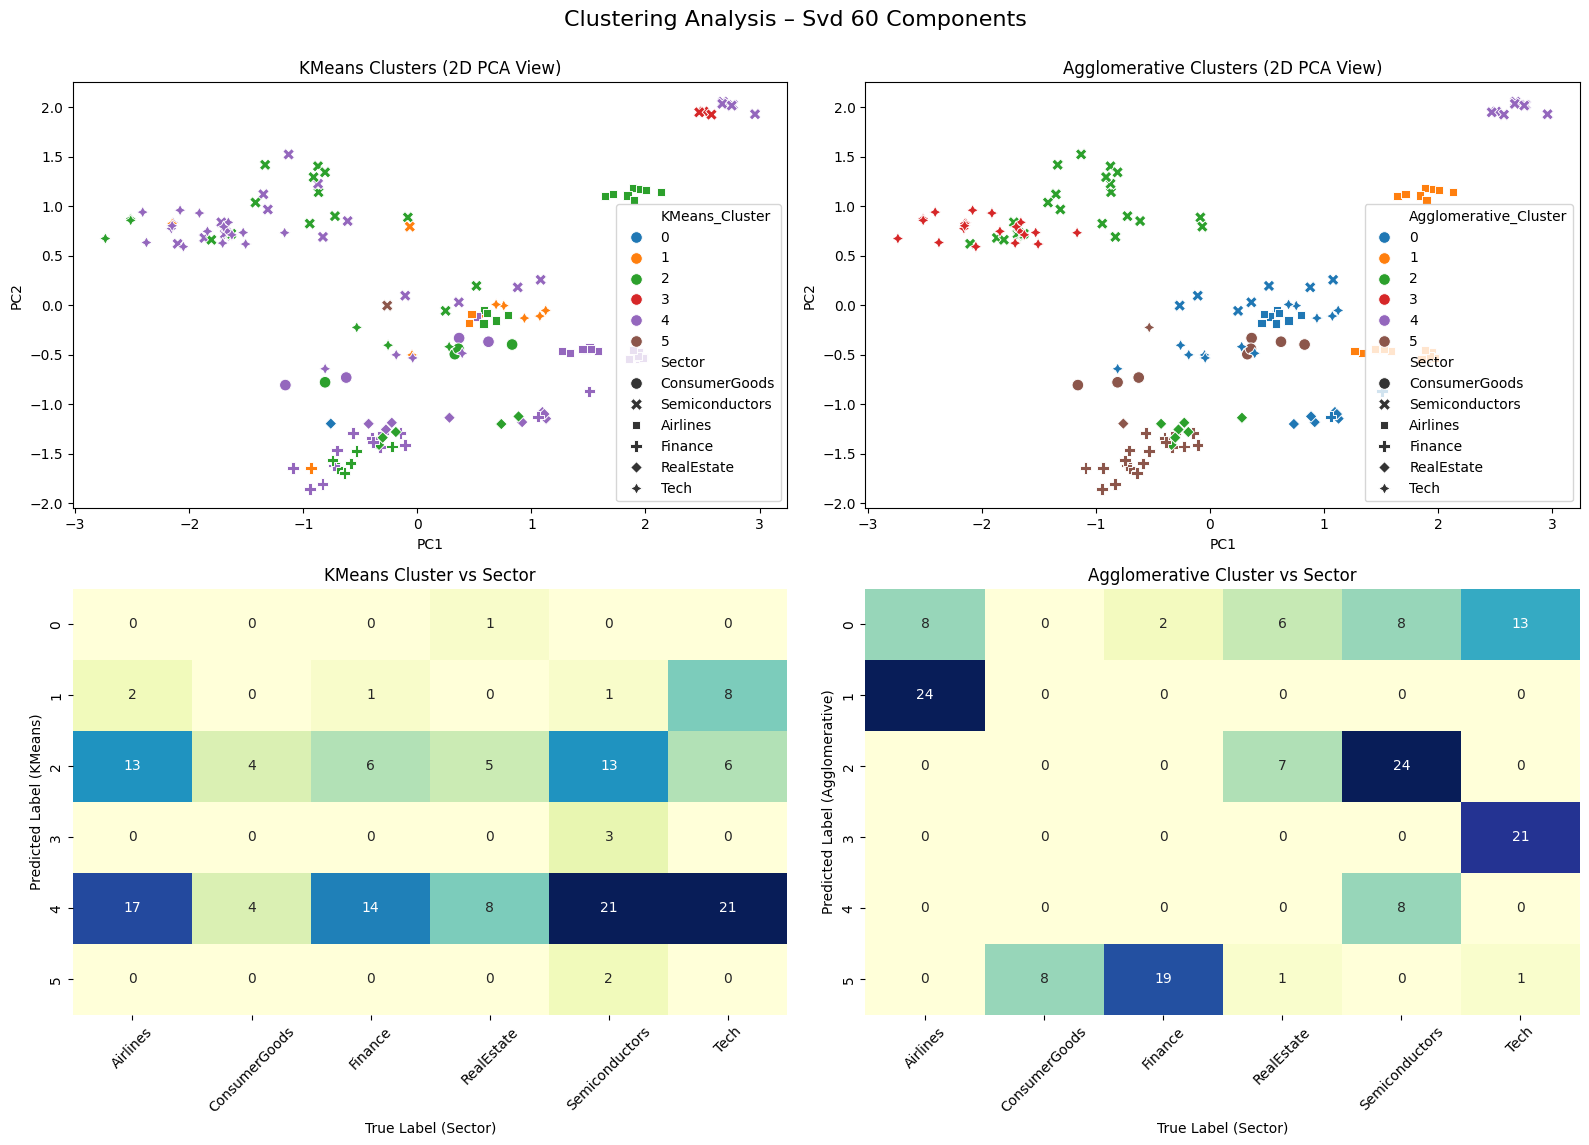

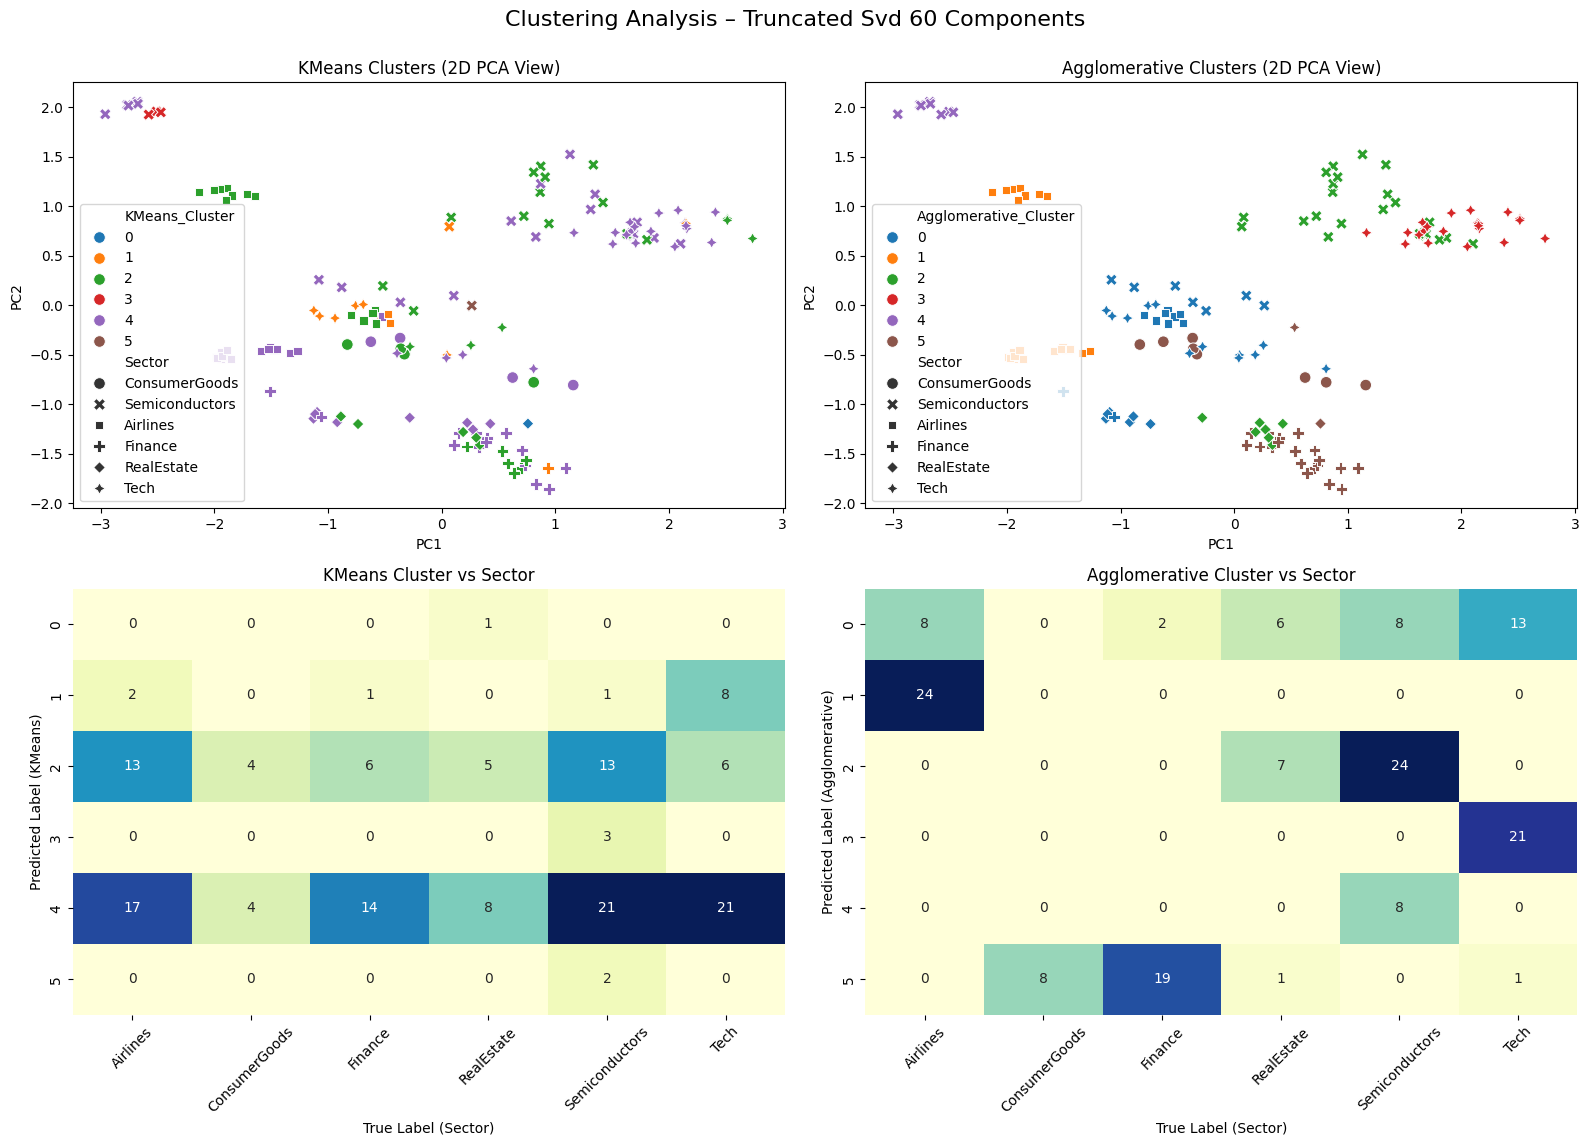

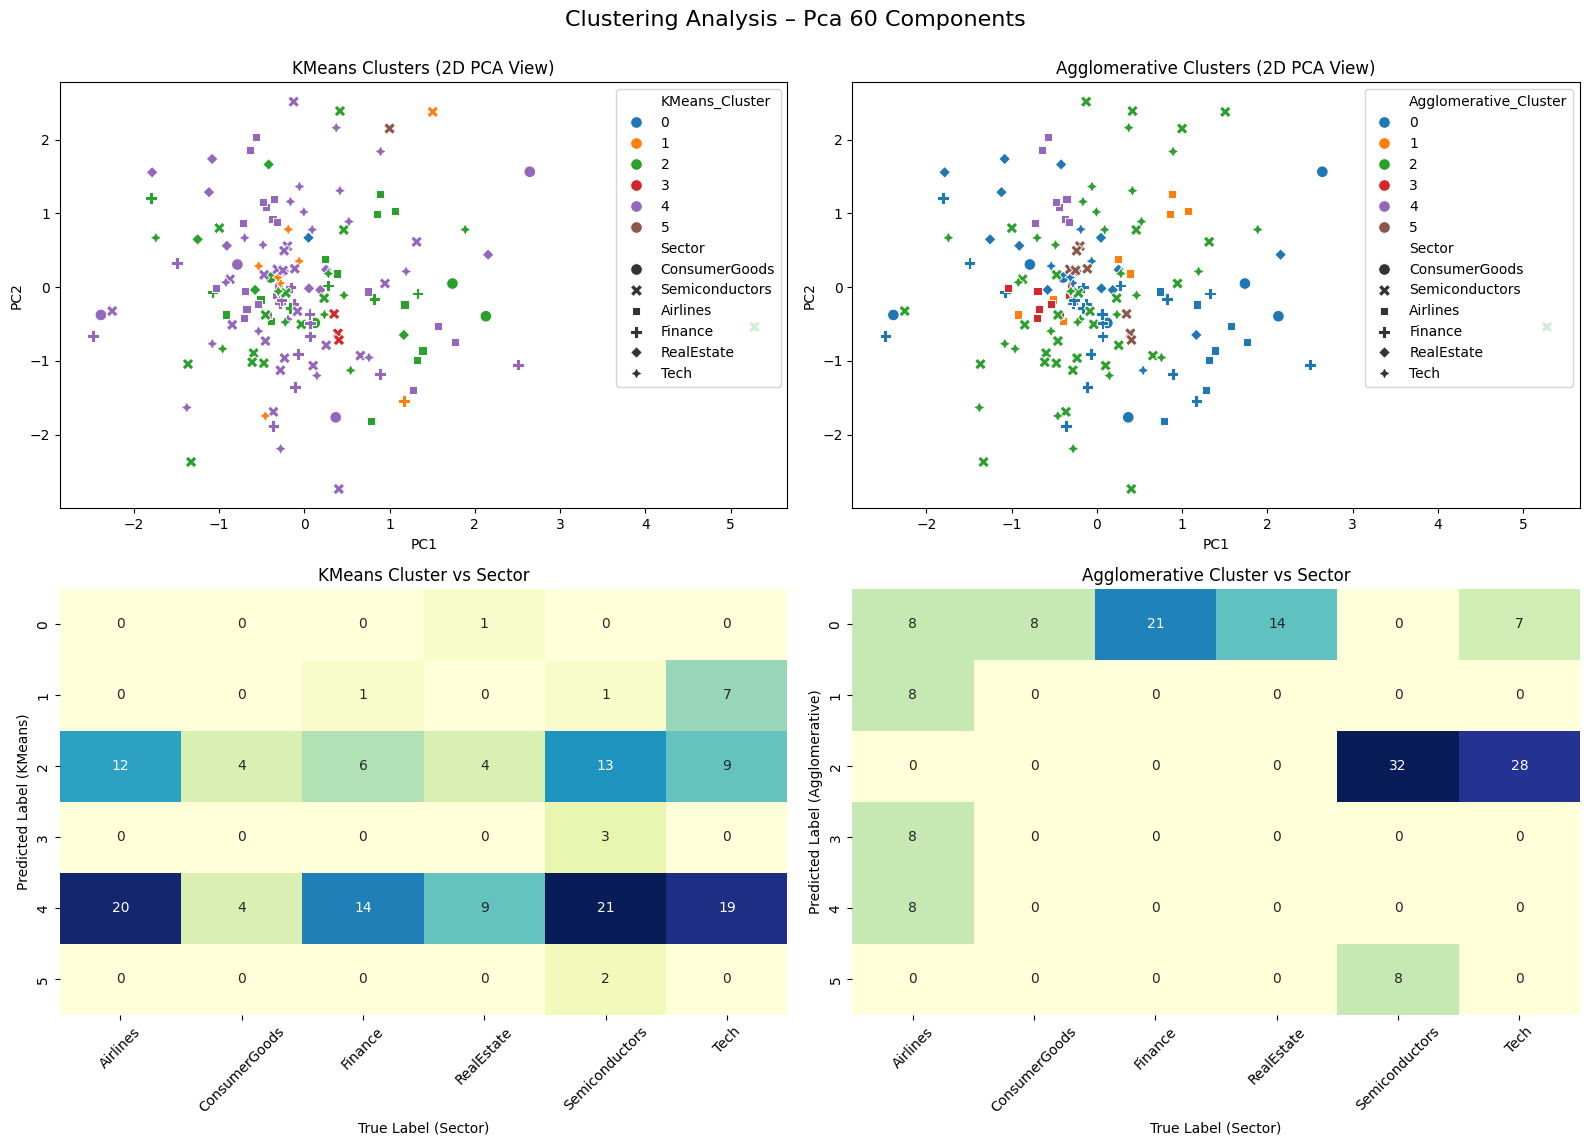

In [15]:
all_scores = []

for components in NUMBER_OF_COMPONENTS:
    files = [
        f"{DATA_PATH}/matrix_completed_svd_{components}_components.csv",
        f"{DATA_PATH}/svd_{components}_components.csv",
        f"{DATA_PATH}/truncated_svd_{components}_components.csv",
        f"{DATA_PATH}/pca_{components}_components.csv"
    ]

    for file in files:
        scores = cluster_and_visualize(file)  # shows plots
        all_scores.extend(scores)

# Make final silhouette score summary table
df_scores = pd.DataFrame(all_scores).sort_values(by=["Dataset", "Method"])

# Looking at the silhouette scores

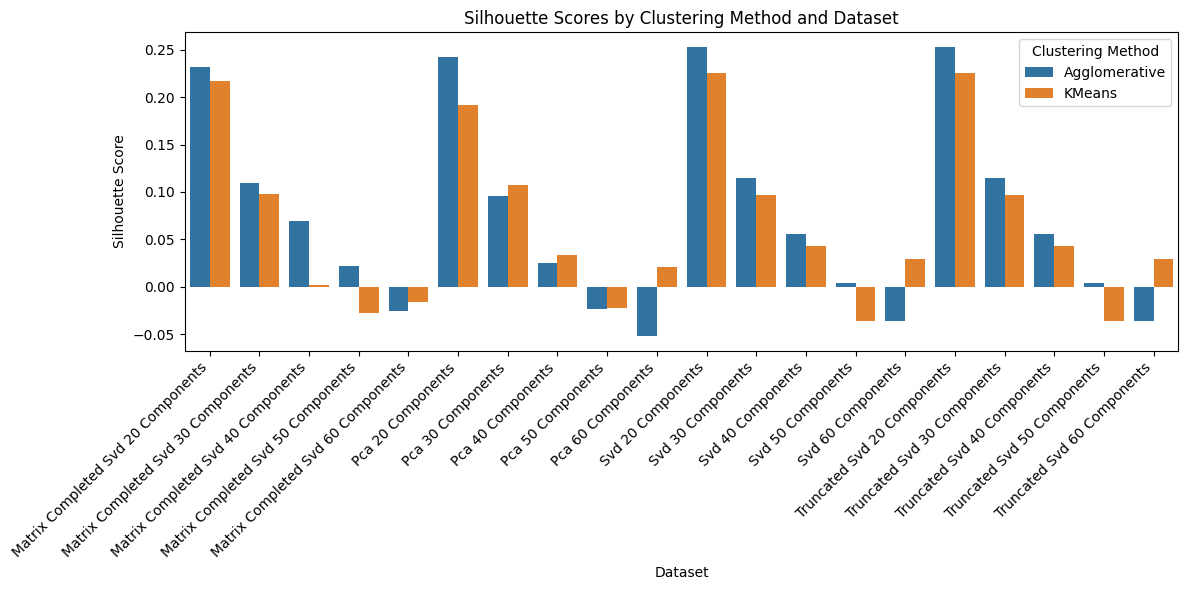

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_scores, x="Dataset", y="Silhouette Score", hue="Method")

plt.title("Silhouette Scores by Clustering Method and Dataset")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Silhouette Score")
plt.xlabel("Dataset")
plt.legend(title="Clustering Method")
plt.tight_layout()
plt.show()

### Takeaways:
- Higher component counts (30–60) probably hurt clustering performance. We believe that this is the case because the additional dimensions introduce noise or generic linguistic patterns that don’t help distinguish sectors.
- Lower-dimensional embeddings (e.g., 20 components) performed the best. These more compact representations appear to capture the most secor-level language variation.